In [2]:
import os
import glob
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('max_rows', 100)
pd.set_option('max_columns', 100)

perc = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]

### 1. internal latency check

In [3]:
# we need to roll out those orders with wrong mrstaat first
startDate = '20201109'
endDate = '20201119'


readPath = r'\\192.168.10.34\random_backup\Kevin_zhenyu\orderLog\equityTradeLogs'
dataPathLs = np.array(glob.glob(os.path.join(readPath, 'speedCompare***.csv')))
dateLs = np.array([os.path.basename(i).split('_')[1].split('.')[0] for i in dataPathLs])
dataPathLs = dataPathLs[(dateLs >= startDate) & (dateLs <= endDate)]
dateLs = np.array([os.path.basename(i).split('_')[1].split('.')[0] for i in dataPathLs])
rawOrderLog = []
for thisDate, thisPath in zip(dateLs, dataPathLs):
    data = pd.read_csv(thisPath)
    data = data.rename(columns={'mdClockAtArrival': 'caamd'})
    rawOrderLog += [data]
rawOrderLog = pd.concat(rawOrderLog, sort=False)

for col in ['clockAtArrival', 'caamd', 'secid', 'updateType', 'vai', 'absFilledThisUpdate', 'orderDirection', 'absOrderSize',
            'absOrderSizeCumFilled', 'date', 'accCode', 'mse']:
    rawOrderLog[col] = rawOrderLog[col].fillna(0).astype('int64')   
rawOrderLog = rawOrderLog.sort_values(by=['date', 'secid', 'vai', 'accCode', 'clockAtArrival']).reset_index(drop=True)

rawOrderLog = rawOrderLog[rawOrderLog["secid"] >= 1000000]

r1 = rawOrderLog[rawOrderLog['accCode'] == 8856]
r2 = rawOrderLog[rawOrderLog['accCode'] != 8856]
r1['test'] = r1.groupby(['date', 'secid', 'orderDirection', 'absOrderSize']).grouper.group_info[0]
r1 = r1.sort_values(by=['test', 'clockAtArrival'])
r1['t1'] = r1[r1['updateType'] == 0].groupby('test')['accCode'].transform('count')
r1['t1'] = r1.groupby('test')['t1'].ffill()
r1.loc[r1['vai'] == -1, 'vai'] = np.nan
r1['vai'] = r1.groupby('test')['vai'].ffill()
rawOrderLog = pd.concat([r1, r2])
del r1
del r2

display('There are accounts with duplicated ticks:')
display(rawOrderLog[rawOrderLog.duplicated(['date', 'secid', 'vai', 'accCode', 'clockAtArrival', 'updateType', \
                                    'orderDirection', 'absOrderSize'], keep=False)]\
.groupby(['date', 'colo', 'accCode'])['ars'].size())
rawOrderLog = rawOrderLog.drop_duplicates(['date', 'secid', 'vai', 'accCode', 'clockAtArrival', 'updateType', \
                                    'orderDirection', 'absOrderSize'], keep='first')
rawOrderLog['clock'] = rawOrderLog['clockAtArrival'].apply(lambda x: datetime.datetime.fromtimestamp(x/1e6))
rawOrderLog['broker'] = rawOrderLog['accCode'] // 100
rawOrderLog["broker"] = np.where(rawOrderLog["accCode"].astype(str).apply(lambda x: len(x) == 6), rawOrderLog['accCode'] // 10000, rawOrderLog["broker"])
rawOrderLog['colo_broker'] = rawOrderLog['colo'].str[:2] + '_' + rawOrderLog['broker'].astype('str')
rawOrderLog['order'] = rawOrderLog.groupby(['date', 'accCode', 'secid', 'vai', 'internalId']).grouper.group_info[0]
rawOrderLog['group'] = rawOrderLog.groupby(['date', 'secid', 'vai']).grouper.group_info[0]
rawOrderLog['startClock'] = rawOrderLog.groupby(['order'])['clockAtArrival'].transform('first')
rawOrderLog['duration'] = rawOrderLog['clockAtArrival'] - rawOrderLog['startClock']
rawOrderLog['orderPrice'] = rawOrderLog['orderPrice'].apply(lambda x: round(x, 2))
rawOrderLog['tradePrice'] = rawOrderLog['tradePrice'].apply(lambda x: round(x, 2))
rawOrderLog['orderDirection1'] = np.where(rawOrderLog["orderDirection"] == -2, -1, np.where(
    rawOrderLog["orderDirection"] == 2, 1, rawOrderLog["orderDirection"]))
orderLog = rawOrderLog.copy()

### Assertion 1:  make sure same direction in same date, secid, vai
print('=======================================================================================')
print('1. same date, secid, vai: same direction')
orderLog['directNum'] = orderLog.groupby(['date', 'secid', 'vai'])['orderDirection1'].transform('nunique')
if len(orderLog[orderLog['directNum'] != 1]) > 0:
    print('opposite direction for same date, same secid, same vai')
    display(orderLog[(orderLog['directNum'] != 1) & (orderLog['updateType'] == 0)][['date', 'accCode', 'secid', 'vai', 'orderDirection', 'order']])
    display(orderLog[(orderLog['directNum'] != 1) & (orderLog['updateType'] == 0)].groupby(['accCode'])['date'].size())
    orderLog = orderLog[orderLog['directNum'] == 1]

assert((orderLog.groupby(['date', 'secid', 'vai'])['orderDirection1'].nunique() == 1).all() == True)

## Assertion 2:  make sure each account, secid, vai only has one insertion
print('=======================================================================================')
print('2. same date, secid, vai, accCode: one insertion')
a = orderLog[orderLog['updateType'] == 0].groupby(['date', 'accCode', 'secid', 'vai', 'order'])['clockAtArrival'].count()
if len(a[a > 1]) > 0:
    print('more than one insertion at same time')
    a = a[a>1].reset_index()
    display(a)
    display(a.groupby(['accCode'])['date'].size())
    orderLog = orderLog[~(orderLog['order'].isin(a['order'].unique()))]

orderLog['isMsg'] = np.where(orderLog['updateType'] == 0, 
                             np.where(orderLog['mse'] == 100, 1, 0), np.nan)
orderLog['isMsg'] = orderLog.groupby(['order'])['isMsg'].ffill()

placeSZE = orderLog[(orderLog['secid'] >= 2000000) & (orderLog['updateType'] == 0)]
print('%.2f%% SZE orders triggered by msg data'%(placeSZE[placeSZE['isMsg'] == 1].shape[0]/placeSZE.shape[0]*100))


### Assertion 3:  check IPO stocks selling status
print('=======================================================================================')
print('3. IPO stocks selling (ars = 301, 302)')
if orderLog[orderLog['ars'].isin([301, 302])].shape[0] != 0:
    kk = orderLog[orderLog['ars'].isin([301, 302])]
    print(kk)
    try:
        assert(kk[kk['orderDirection1'] == 1].shape[0] == 0)
        print('we only sell, never buy')
    except:
        print('There are IPO buy side orders!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        print(kk[kk['orderDirection1'] == 1])
    kk1 = kk[kk['updateType'] == 0]
    kk1 = kk1.sort_values(by=['accCode', 'secid','clockAtArrival'])
    kk1['diff'] = kk1.groupby(['accCode', 'secid'])['clockAtArrival'].apply(lambda x: x-x.shift(1))
    kk1 = kk1[~kk1['diff'].isnull()]
    try:
        assert(kk1[kk1['diff'] < 10e6].shape[0] == 0)
        print('for each stock in the same account, there is no insertion within 10 seconds of the previous insertion')
    except:
        print('There are insertion within 10 seconds for orders under same account same stock!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        print(kk1[kk1['diff'] < 10e6])
    kk2 = kk[(kk['updateType'] == 1)]
    try:
        assert(kk2[kk2['duration'] < 3e6].shape[0] == 0)
        print('for each stock in the same account, the cancellation of an order happens more than 3 seconds after the insertion')
    except:
        print('There are cancellation within 3 seconds for orders under same account same stock!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        print(kk2[kk2['duration'] < 3e6])


### Assertion 4: check updateType == 7 orders, make sure updateType == 7 orders < 20 per account, < 100 in total
print('=======================================================================================')
print('4. updateType 7 orders')
if orderLog[orderLog['updateType'] == 7].shape[0] != 0:
    assert(orderLog[orderLog['updateType'] == 7].groupby(['date', 'accCode'])['order'].nunique().max() < 20)
    assert(orderLog[orderLog['updateType'] == 7].groupby(['date', 'accCode'])['order'].nunique().sum() < 100)

### Assertion 5: check updateType == 6 orders, make sure updateType == 6 orders < 5% per account
print('=======================================================================================')
print('5. updateType 6 orders')
k1 = orderLog[orderLog['updateType'] == 6].groupby(['date', 'accCode'])['order'].nunique().reset_index()
k2 = orderLog.groupby(['date', 'accCode'])['order'].nunique().reset_index()
k = pd.merge(k1, k2, on=['date', 'accCode'], how='left')
k['prob'] = k['order_x']/k['order_y']
try:
    assert(sum(k['prob'] >= 0.05) == 0)
except:
    print('There are accounts with more than 5% updateType 6 orders!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
    print(k[k['prob'] >= 0.05])

### Assertion 6: check CYB orders, make sure CYB stocks total absOrderSize < 30w
print('=======================================================================================')
print('6. CYB stocks total order size < 30w')
try:
    cyb = orderLog[(orderLog['secid'] >= 2300000) & (orderLog['updateType'] == 0)].groupby('date')['absOrderSize'].max().reset_index()
    assert(cyb[cyb['absOrderSize'] > 300000].shape[0] == 0)
except:
    print('CYB stocks total absOrderSize >= 30w!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
    
     
### Assertion 7:  make sure there is no unexpected updateType 
print('=======================================================================================')
print('7. unexpected updateType')
def getTuple(x):
    return tuple(i for i in x)

checkLog = orderLog[~((orderLog['updateType'] == 4) & (orderLog.groupby(['order'])['updateType'].shift(-1) == 4))]
checkLog = checkLog.groupby(['order'])['updateType'].apply(lambda x: getTuple(x)).reset_index()
checkLog['status'] = np.where(checkLog['updateType'].isin([(0, 2, 4), (0, 2, 1, 4), (0, 2, 1, 2, 4), (0, 2, 4, 1, 4), (0, 4), (0, 1, 4), (0, 4, 1, 4), (0, 2, 2, 4), (0, 4, 2, 4), (0, 2, 2, 1, 4), (0, 2, 2, 4, 1, 4)]),0,
                     np.where(checkLog['updateType'].isin([(0, 2, 4, 1, 3), (0, 2, 4, 1, 4, 3), (0, 2, 1, 4, 3), (0, 4, 1, 3), (0, 1, 4, 3),
                                                               (0, 2, 2, 4, 1, 3), (0, 2, 2, 4, 1, 4, 3), (0, 2, 2, 1, 4, 3), (0, 4, 2, 4, 1, 3),
                                                               (0, 4, 2, 1, 3), (0, 4, 1, 4, 3), (0, 4, 1)]), 1,
                     np.where(checkLog['updateType'].isin([(0, 2, 1, 3), (0, 2, 2, 1, 3), (0, 2, 3), (0, 3), (0, 1, 3), (0, ), (0, 2), (0, 2, 1), (0, 2, 2)]), 2, 3)))

orderLog = pd.merge(orderLog, checkLog[['order', 'status']], how='left', on=['order'], validate='many_to_one')
orderLog = orderLog[orderLog['status'].isin([0, 1, 2])].reset_index(drop=True)

### Assertion 8:  make sure status==0 got all traded
print('=======================================================================================')
print('8. status == 0: all traded')
a = orderLog[orderLog['status'] == 0]
a = a.groupby(['order'])[['absOrderSizeCumFilled', 'absOrderSize']].max().reset_index()
a.columns = ['order', 'filled', 'total']
print('in total trade, any fill != total cases')
display(a[a['filled'] != a['total']])
if a[a['filled'] != a['total']].shape[0] > 0:
    removeOrderLs = a[a['filled'] != a['total']]['order'].unique()
    orderLog = orderLog[~(orderLog['order'].isin(removeOrderLs))]
    
### Assertion 9:  make sure status==1 got partial traded
print('=======================================================================================')
print('9. status == 1: partial traded')
a = orderLog[orderLog['status'] == 1]
a = a.groupby(['order'])[['absOrderSizeCumFilled', 'absOrderSize']].max().reset_index()
a.columns = ['order', 'filled', 'total']
print('in partial trade, any fill >= total or fill is 0 cases for updateType 4')
display(a[(a['filled'] >= a['total']) | (a['filled'] == 0)])
if a[(a['filled'] >= a['total']) | (a['filled'] == 0)].shape[0] > 0:
    removeOrderLs = a[(a['filled'] >= a['total']) | (a['filled'] == 0)]['order'].unique()
    orderLog = orderLog[~(orderLog['order'].isin(removeOrderLs))]
    
### Assertion 10: make sure no cancellation within 1 sec
print('=======================================================================================')
print('10. no cancellation within 1 sec')
a = orderLog[(orderLog['updateType'] == 1) & (orderLog['duration'] < 1e6)]
print('any cancellation within 1 sec')
display(a)
if a.shape[0] > 0:
    removeOrderLs = a['order'].unique()
    orderLog = orderLog[~(orderLog['order'].isin(removeOrderLs))]


### Assertion 11: make sure no order has shares > 80w or notional > 800w
print('=======================================================================================')
print('11. Orders with size > 80w or notional > 800w')
orderLog['orderNtl'] = orderLog['absOrderSize'] * orderLog['orderPrice']
if orderLog[orderLog['absOrderSize'] > 800000].shape[0] > 0:
    print('some order quantity are > 80w')
    print(orderLog[orderLog['absOrderSize'] > 800000].groupby(['colo', 'accCode'])['order'].nunique())
    display(orderLog[orderLog['absOrderSize'] > 800000][['date', 'accCode', 'secid', 'vai', 'absOrderSize', 'orderPrice',
                                                         'orderNtl', 'orderDirection', 'clock', 'order']])
            
if orderLog[orderLog['orderNtl'] > 8000000].shape[0] > 0:
    print('some order ntl are > 800w')
    print(orderLog[orderLog['orderNtl'] > 8000000].groupby(['colo', 'accCode'])['order'].nunique())
    display(orderLog[orderLog['orderNtl'] > 8000000][['date', 'accCode', 'secid', 'vai', 'absOrderSize', 'orderPrice',
                                                      'orderNtl', 'orderDirection', 'clock', 'order', "updateType", 
                                                      "tradePrice", "absOrderSizeCumFilled", "absFilledThisUpdate"]])

removeOrderLs = list(set(orderLog[orderLog['absOrderSize'] > 800000]['order'].unique()) | set(orderLog[orderLog['orderNtl'] > 8000000]['order'].unique()))
orderLog = orderLog[~(orderLog['order'].isin(removeOrderLs))]


orderLog = orderLog.sort_values(by=['date', 'secid', 'vai', 'accCode', 'clockAtArrival']).reset_index(drop=True)

orderLog['exchange'] = np.where(orderLog['secid'] >= 2000000, 'SZE', 'SSE')
orderLog['orderNtl'] = orderLog['orderPrice'] * orderLog['absOrderSize']
orderLog['tradeNtl'] = np.where(orderLog['updateType'] == 4, orderLog['tradePrice']*orderLog['absFilledThisUpdate'], 0)
orderLog["mrstaat"] = orderLog.groupby(['order'])['mrstaat'].transform('first')
orderLog["ars"] = orderLog.groupby(['order'])['ars'].transform('first')
orderLog["sdd"] = orderLog.groupby(['order'])['sdd'].transform('first')
orderLog["mrstauc"] = orderLog.groupby(['order'])['mrstauc'].transform('first')

C:\Users\win\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\win\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (15,16,21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\win\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\win\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (15,16,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=res

'There are accounts with duplicated ticks:'

date      colo      accCode
20201112  zs_96_08  974101     27542
          zt_88_06  8971       25984
Name: ars, dtype: int64

1. same date, secid, vai: same direction
opposite direction for same date, same secid, same vai


,date,accCode,secid,vai,orderDirection,order
41110,20201109,6237,1600258,20086312.0,1,88062
41115,20201109,6282,1600258,20086312.0,1,89526
41119,20201109,9441,1600258,20086312.0,-1,143724
207016,20201109,6237,1601966,7559595.0,-1,88274
207020,20201109,6282,1601966,7559595.0,1,89701
...,...,...,...,...,...,...
8653679,20201119,9758,2300653,546870.0,1,2061400
8653683,20201119,9758,2300653,546870.0,-1,2061401
8653687,20201119,9758,2300653,546870.0,-1,2061402
8680228,20201119,9685,2300725,993639.0,-1,2043024


accCode
5222        1
5226        1
5229        1
5275       10
5276        1
5287        2
5289        5
5291        1
5332        4
5377        4
5386        2
5456       15
6237      209
6282      208
6480        1
6623        4
6627        4
6683        2
8833        6
8854        9
8865        1
8886        8
8924        4
8943        2
8967        1
9208        5
9248        2
9441       81
9454        1
9461        1
9471        5
9551        1
9685        2
9741        1
9754       12
9756        1
9758       36
522201      3
522401      9
522501      1
522601      8
523001      7
523201      3
526901      1
527101      1
527301      7
527601      1
528401      2
528701      1
528901      1
537403      6
896702      4
897002      7
965801      2
966301      8
966501      4
968501      1
Name: date, dtype: int64

2. same date, secid, vai, accCode: one insertion
99.73% SZE orders triggered by msg data
3. IPO stocks selling (ars = 301, 302)
4. updateType 7 orders
5. updateType 6 orders
There are accounts with more than 5% updateType 6 orders!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        date  accCode  order_x  order_y      prob
27  20201113     6282      154     1906  0.080797
6. CYB stocks total order size < 30w
7. unexpected updateType
8. status == 0: all traded
in total trade, any fill != total cases


,order,filled,total
1785,2712,400,500
2815,4214,9400,9700
24492,32174,300,400
26039,34223,300,400
42386,54771,5164,11700
...,...,...,...
1513261,2102607,500,2500
1514323,2104109,700,6500
1521918,2115386,9900,34300
1523334,2117346,400,800


9. status == 1: partial traded
in partial trade, any fill >= total or fill is 0 cases for updateType 4


,order,filled,total


10. no cancellation within 1 sec
any cancellation within 1 sec


,ApplSeqNum,Unnamed: 0,aaa,absFilledThisUpdate,absOrderSize,absOrderSizeCumFilled,accCode,ars,caamd,cancellationPending,cfe,clock,clockAtArrival,colo,date,finalState,hee,internalId,l4tr,mfe,mra100,mrb100,mrm,mrrlma,mrsb300,mrsb90,mrss300,mrss90,mrstaat,mrstauc,mrstaum,ms,mse,mt,mta,orderDirection,orderId,orderPrice,orderSysId,sdd,secid,sequenceNo,session,t1,test,threadId,tradeId,tradePrice,underlyingIndex,updateType,vai,broker,colo_broker,order,group,startClock,duration,orderDirection1,directNum,isMsg,status


11. Orders with size > 80w or notional > 800w
some order ntl are > 800w
colo      accCode
zt_52_05  527501     1
zt_88_06  8971       2
Name: order, dtype: int64


,date,accCode,secid,vai,absOrderSize,orderPrice,orderNtl,orderDirection,clock,order,updateType,tradePrice,absOrderSizeCumFilled,absFilledThisUpdate
1972323,20201111,8971,1600031,68524384.0,277800,28.80,8000640.0,1,2020-11-11 13:04:54.879842,606942,0,-1.00,0,0
1972324,20201111,8971,1600031,68524384.0,277800,28.80,8000640.0,1,2020-11-11 13:04:55.034330,606942,2,-1.00,0,0
1972325,20201111,8971,1600031,68524384.0,277800,28.80,8000640.0,1,2020-11-11 13:04:55.275614,606942,4,28.80,300,300
1972326,20201111,8971,1600031,68524384.0,277800,28.80,8000640.0,1,2020-11-11 13:04:55.275760,606942,4,28.80,406,106
1972327,20201111,8971,1600031,68524384.0,277800,28.80,8000640.0,1,2020-11-11 13:04:55.275903,606942,4,28.80,2406,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5010752,20201116,8971,1600585,19334231.0,141600,56.50,8000400.0,1,2020-11-16 11:02:11.658279,1324019,1,-1.00,121300,0
5010753,20201116,8971,1600585,19334231.0,141600,56.50,8000400.0,1,2020-11-16 11:02:11.855766,1324019,3,-1.00,121300,0
5096327,20201116,527501,1601318,45272703.0,96400,82.99,8000236.0,1,2020-11-16 13:10:32.492969,1394954,0,-1.00,0,0
5096328,20201116,527501,1601318,45272703.0,96400,82.99,8000236.0,1,2020-11-16 13:10:32.672539,1394954,2,-1.00,0,0


In [5]:
# orderLog['server_account'] = orderLog['colo'].apply(lambda x: x.replace('_', '')) + '_' + orderLog['accCode'].astype(str)
# orderLog = orderLog[~orderLog['ars'].isnull()]
# orderLog = orderLog[(~orderLog["mrstaat"].isnull()) & (orderLog['mrstaat'] != 0) & (orderLog['mrstaat'] != 2000)]
# orderLog = orderLog[orderLog['ars']//1%10 == 1]
# orderLog[(orderLog['server_account'] == 'zs9608_6282') & (orderLog['updateType'] == 0) & (orderLog['sdd'] > 94200000)].groupby('date')['absOrderSize'].sum()

date
20201014    2827689
20201015    2702853
20201016    2627659
20201019    1840390
20201020    1993916
20201021    1797273
20201022    1831900
20201027     363800
20201028      89000
20201029      31700
20201030      61300
20201105       3100
20201106       4800
Name: absOrderSize, dtype: int64

In [4]:
orderLog = orderLog[~orderLog['ars'].isnull()]
orderLog.loc[(orderLog['date'] <= 20201013) & (orderLog['ars'].isin([121, 131])), 'mrstauc'] = 1000
orderLog.loc[(orderLog['date'] <= 20201013) & (orderLog['ars'].isin([221, 231])), 'mrstauc'] = 2000
orderLog.loc[(orderLog['date'] <= 20201013) & (orderLog['ars'].isin([321, 331])), 'mrstauc'] = 3000
orderLog.loc[(orderLog['date'] <= 20201013) & (~orderLog['ars'].isin([121, 221, 321, 131, 231, 331])), 'mrstauc'] = 0
orderLog.loc[(orderLog['date'] <= 20201013) & (orderLog['mrstauc'].isin([1000, 2000, 3000])), 'mrstaat'] = 3000
orderLog.loc[(orderLog['date'] <= 20201013) & (orderLog['mrstauc'] == 0), 'mrstaat'] = 1000

In [5]:
orderLog = orderLog[(~orderLog["mrstaat"].isnull()) & (orderLog['mrstaat'] != 0) & (orderLog['mrstaat'] != 2000)]
orderLog['sta'] = np.where(orderLog['mrstaat'] == 1000, '1. staone', np.where(
orderLog['mrstaat'] == 3000, '2. statwo',  '3. sta300'))
orderLog.loc[orderLog['mrstauc'] == 2, 'mrstauc'] = 0

In [52]:
orderLog['ars'].unique()

array([1., 3., 2.])

In [6]:
# all taking orders
orderLog = orderLog[orderLog['ars']%10 == 1]

In [8]:
orderLog['m1'] = orderLog['mrstaat'].apply(lambda x: x - (x // 10000) * 10000)
orderLog['m2'] = orderLog['mrstauc'].apply(lambda x: x - (x // 10000) * 10000)

In [16]:
orderLog[orderLog['mrsb90'] == '0.001779']

,Unnamed: 0,date,clockAtArrival,caamd,colo,accCode,secid,vai,sdd,orderDirection,absOrderSize,updateType,tradePrice,absFilledThisUpdate,absOrderSizeCumFilled,tradeId,orderSysId,aaa,internalId,ars,mse,mta,mrstaat,session,cfe,mrss90,mrstauc,mra100,orderId,underlyingIndex,mt,mrsb90,mrm,mrss,mrsb300,orderPrice,l4tr,hee,mrb100,cancellationPending,mrss300,mfe,mrsb,threadId,ms,finalState,sequenceNo,ApplSeqNum,clock,mrstaum,mrrlma,broker,colo_broker,order,group,startClock,duration,orderDirection1,directNum,isMsg,status,orderNtl,exchange,tradeNtl,server_account,sta,m1,m2
10834109,1034708,20201029,1603949130709535,1603949130709463,zs_94_05,9451,2300807,3064571,132529120.0,1,200,0,-1.0,0,0,NaN,NaN,0.002302,1015.0,1.0,100,0.001984,13000.0,0,539099.0475,-0.001832,11000.0,4452.0,-1.0,852,0.0,0.001779,0.001984,NaN,0.002407,44.52,0.0,0.002125,4451.0,0.0,-0.002625,-1.0,NaN,5214.0,13:25:30.708343,0.0,162056760.0,15816254.0,2020-10-29 13:25:30.709535,1.0,NaN,94,zs_94,2594551,1376543,1603949130709535,0,1,1,1.0,0,8904.0,SZE,0.0,zs9405_9451,stathree23,3000.0,1000.0


In [9]:
# orderLog['mrsb90'] = orderLog.groupby(['order'])['mrsb90'].transform('first')
# orderLog['aaa'] = orderLog.groupby(['order'])['aaa'].transform('first')
display(orderLog[orderLog['mrsb90'] == '-'])
orderLog = orderLog[orderLog['mrsb90'] != '-']
orderLog['mrsb90'] = orderLog['mrsb90'].astype(float)
display(orderLog[orderLog['aaa'] == '-'])
orderLog = orderLog[orderLog['aaa'] != '-']
orderLog['aaa'] = orderLog['aaa'].astype(float)
orderLog.loc[(orderLog['updateType'] == 0) & (orderLog['orderDirection'] >= 1) &\
         (orderLog['mrstaat'].isin([11000, 13000])) & (abs(orderLog['aaa'] - orderLog['mrsb90']) < 1e-12), 'mrstauc'] = \
orderLog.loc[(orderLog['updateType'] == 0) & (orderLog['orderDirection'] >= 1) &\
         (orderLog['mrstaat'].isin([11000, 13000])) & (abs(orderLog['aaa'] - orderLog['mrsb90']) < 1e-12), 'm2']

orderLog.loc[(orderLog['updateType'] == 0) & (orderLog['orderDirection'] >= 1) &\
         (orderLog['mrstaat'].isin([11000, 13000])) & (abs(orderLog['aaa'] - orderLog['mrsb90']) < 1e-12), 'mrstaat'] = \
orderLog.loc[(orderLog['updateType'] == 0) & (orderLog['orderDirection'] >= 1) &\
         (orderLog['mrstaat'].isin([11000, 13000])) & (abs(orderLog['aaa'] - orderLog['mrsb90']) < 1e-12), 'm1']

,ApplSeqNum,Unnamed: 0,aaa,absFilledThisUpdate,absOrderSize,absOrderSizeCumFilled,accCode,ars,caamd,cancellationPending,cfe,clock,clockAtArrival,colo,date,finalState,hee,internalId,l4tr,mfe,mra100,mrb100,mrm,mrrlma,mrsb300,mrsb90,mrss300,mrss90,mrstaat,mrstauc,mrstaum,ms,mse,mt,mta,orderDirection,orderId,orderPrice,orderSysId,sdd,secid,sequenceNo,session,t1,test,threadId,tradeId,tradePrice,underlyingIndex,updateType,vai,broker,colo_broker,order,group,startClock,duration,orderDirection1,directNum,isMsg,status,orderNtl,exchange,tradeNtl,sta,m1,m2


,ApplSeqNum,Unnamed: 0,aaa,absFilledThisUpdate,absOrderSize,absOrderSizeCumFilled,accCode,ars,caamd,cancellationPending,cfe,clock,clockAtArrival,colo,date,finalState,hee,internalId,l4tr,mfe,mra100,mrb100,mrm,mrrlma,mrsb300,mrsb90,mrss300,mrss90,mrstaat,mrstauc,mrstaum,ms,mse,mt,mta,orderDirection,orderId,orderPrice,orderSysId,sdd,secid,sequenceNo,session,t1,test,threadId,tradeId,tradePrice,underlyingIndex,updateType,vai,broker,colo_broker,order,group,startClock,duration,orderDirection1,directNum,isMsg,status,orderNtl,exchange,tradeNtl,sta,m1,m2


In [10]:
orderLog.loc[(orderLog['updateType'] == 0) & (orderLog['orderDirection'] < 1) &\
         (orderLog['mrstaat'].isin([11000, 13000])) & (abs(orderLog['aaa'] - orderLog['mrss90']) < 1e-12), 'mrstauc'] = \
orderLog.loc[(orderLog['updateType'] == 0) & (orderLog['orderDirection'] < 1) &\
         (orderLog['mrstaat'].isin([11000, 13000])) & (abs(orderLog['aaa'] - orderLog['mrss90']) < 1e-12), 'm2']

orderLog.loc[(orderLog['updateType'] == 0) & (orderLog['orderDirection'] < 1) &\
         (orderLog['mrstaat'].isin([11000, 13000])) & (abs(orderLog['aaa'] - orderLog['mrss90']) < 1e-12), 'mrstaat'] = \
orderLog.loc[(orderLog['updateType'] == 0) & (orderLog['orderDirection'] < 1) &\
         (orderLog['mrstaat'].isin([11000, 13000])) & (abs(orderLog['aaa'] - orderLog['mrss90']) < 1e-12), 'm1']

In [10]:
orderLog['mrstaat'].unique()

array([ 3000.,  1000., 13000., 11000.])

In [11]:
orderLog['sta'] = np.where(orderLog['mrstaat'] == 1000, '1. staone', np.where(
orderLog['mrstaat'] == 3000, '2. statwo',  '3. sta300'))
orderLog.loc[orderLog['mrstauc'] == 2, 'mrstauc'] = 0
orderLog['server_account'] = orderLog['colo'].apply(lambda x: x.replace('_', '')) + '_' + orderLog['accCode'].astype(str)

In [12]:
orderLog['server_account'] = orderLog['colo'].apply(lambda x: x.replace('_', '')) + '_' + orderLog['accCode'].astype(str)
orderLog[(orderLog['sta'].isin(['3. sta300'])) & (orderLog['updateType'] == 0)].groupby(['date', 'server_account'])['secid'].nunique()

date      server_account
20201109  zs8804_8924        268
          zs8804_896702      219
          zs9405_9451        326
          zs9606_9756        976
          zt5205_537403      138
20201110  zs8804_8924        266
          zs8804_896702      191
          zs9405_9451        335
          zs9606_9756       1036
          zt5205_537403      109
          zt9609_965801      180
20201111  zs8804_8924        280
          zs8804_896702      222
          zs9606_9756       1030
          zt5205_537403      147
          zt8806_8943        218
          zt9406_9551        235
20201112  zs8804_8924        273
          zs8804_896702      201
          zs9606_9756        928
          zt5205_537403      125
          zt8806_8943        191
          zt9406_9551        215
20201113  zs8804_8924        240
          zs8804_896702      183
          zs9606_9756        972
          zt5205_537403      124
          zt8806_8943        184
          zt9406_9551        204
20201116  zs8804_8

In [13]:
orderLog.to_pickle(r'F:\orderLog.pkl')

In [33]:
orderLog = pd.read_pickle(r'F:\orderLog.pkl')

In [10]:
checkLog = orderLog[(orderLog["updateType"] == 0)]
checkLog = checkLog[checkLog['caamd'] != 0]
checkLog['internal_latency'] = checkLog["clockAtArrival"] - checkLog["caamd"]
checkLog['accountNum'] = checkLog.groupby(['date', 'sta'])['accCode'].transform('nunique')
re = checkLog.groupby(['date', 'sta'])['internal_latency'].describe().reset_index()
re = pd.merge(re, checkLog.groupby(['date', 'sta'])['accountNum'].first().reset_index(), on=['date', 'sta'])
re = re[['date', 'sta', 'count', 'accountNum', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]
for i in re.columns[re.columns != 'sta']:
    re[i] = re[i].astype('int64')
    
from IPython.display import display, HTML
HTML(re.groupby(['date', 'sta'])[['count', 'accountNum', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']].first().to_html())

In [25]:
orderLog[(orderLog['sta'].isin(['3. stathree13', '4. stathree23'])) & (orderLog['updateType'] == 0)].groupby(['date', 'server_account'])['secid'].nunique()

date      server_account
20201014  zs9405_9451        240
20201015  zs9405_9451        290
20201016  zs9405_9451        317
20201019  zs9405_9451        295
          zt5205_537403      107
          zt9609_965801      195
20201020  zs9405_9451        305
          zt5205_537403      108
          zt9609_965801      166
20201021  zs9405_9451        336
          zs9608_6282        232
          zt5205_537403      105
          zt9609_965801      190
20201022  zs9405_9451        302
          zs9608_6282        225
          zt5205_537403      117
          zt9609_965801      189
20201023  zs9405_9451        345
          zt5205_537403      130
          zt9609_965801      197
20201026  zs9405_9451        322
          zt5205_537403      115
          zt9609_965801      175
20201027  zs9405_9451        289
          zt5205_537403      103
          zt9609_965801      158
20201028  zs9405_9451        309
          zt5205_537403      127
          zt9609_965801      176
20201029  zs9405_9

In [162]:
orderLog[(orderLog['sta'] == '2. statwo') & (orderLog['date'] >= 20201014) & (orderLog['order'] == 3373581)][['mrstauc', 'mrstaat', 'm1', 'm2']]

,mrstauc,mrstaat,m1,m2
13018347,11000.0,3000.0,3000.0,1000.0


In [66]:
checkLog1 = orderLog[(orderLog['server_account'].isin(['zt8806_8943', 'zt9406_9551'])) & (orderLog['date'] < 20201111)]
checkLog2 = orderLog[(orderLog['server_account'].isin(['zt8806_8943', 'zt9406_9551'])) & (orderLog['date'] >= 20201111)]
checkLog1['tag'] = 'before rollout'
checkLog2['tag'] = 'after rollout'
checkLog = pd.concat([checkLog1, checkLog2])
checkLog = checkLog[(checkLog["updateType"] == 0)]
checkLog = checkLog[checkLog['caamd'] != 0]
checkLog['nn'] = checkLog.groupby(['server_account', 'secid'])['tag'].transform('nunique')
checkLog = checkLog[checkLog['nn'] == 2]
checkLog['internal_latency'] = checkLog["clockAtArrival"] - checkLog["caamd"]
re = checkLog.groupby(['tag', 'sta', 'mrstauc'])['internal_latency'].describe().reset_index()
re = re[['tag', 'sta', 'mrstauc', 'count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]
re = re.fillna(0)
for i in re.columns[(re.columns != 'tag') & (re.columns != 'sta')]:
    re[i] = re[i].astype('int64')
    
from IPython.display import display, HTML
HTML(re.groupby(['tag', 'sta', 'mrstauc'])[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']].first().to_html())

C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [15]:
rawOrderLog[(rawOrderLog['colo'] == 'zs_96_06') & (rawOrderLog['accCode'] == 975601)]['date'].unique()

array([20201117, 20201118, 20201119], dtype=int64)

In [67]:
checkLog1 = orderLog[(orderLog['server_account'].isin(['zs9606_975601'])) & (orderLog['date'] < 20201117)]
checkLog2 = orderLog[(orderLog['server_account'].isin(['zs9606_975601'])) & (orderLog['date'] >= 20201117)]
checkLog1['tag'] = 'before rollout'
checkLog2['tag'] = 'after rollout'
checkLog = pd.concat([checkLog1, checkLog2])
checkLog = checkLog[(checkLog["updateType"] == 0)]
checkLog = checkLog[checkLog['caamd'] != 0]
checkLog['nn'] = checkLog.groupby(['server_account', 'secid'])['tag'].transform('nunique')
checkLog = checkLog[checkLog['nn'] == 2]
checkLog['internal_latency'] = checkLog["clockAtArrival"] - checkLog["caamd"]
re = checkLog.groupby(['tag'])['internal_latency'].describe().reset_index()
re = re[['tag', 'count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]
re = re.fillna(0)
for i in re.columns[(re.columns != 'tag') & (re.columns != 'sta')]:
    re[i] = re[i].astype('int64')
    
from IPython.display import display, HTML
HTML(re.groupby(['tag'])[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']].first().to_html())

C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,count,mean,std,min,25%,50%,75%,max
tag,,,,,,,,
after rollout,10761,118,124,33,71,88,128,6933
before rollout,14377,86,143,9,55,70,104,12475


In [16]:
checkLog1 = orderLog[(orderLog['sta'] == '3. sta300') & (orderLog['date'] < 20201117)]
checkLog2 = orderLog[(orderLog['sta'] == '3. sta300') & (orderLog['date'] >= 20201117)]
checkLog1['tag'] = 'before rollout'
checkLog2['tag'] = 'after rollout'
checkLog = pd.concat([checkLog1, checkLog2])
checkLog = checkLog[(checkLog["updateType"] == 0)]
checkLog = checkLog[checkLog['caamd'] != 0]
checkLog['internal_latency'] = checkLog["clockAtArrival"] - checkLog["caamd"]
re = checkLog.groupby(['tag'])['internal_latency'].describe().reset_index()
re = re[['tag', 'count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]
re = re.fillna(0)
for i in re.columns[(re.columns != 'tag') & (re.columns != 'sta')]:
    re[i] = re[i].astype('int64')
    
from IPython.display import display, HTML
HTML(re.groupby(['tag'])[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']].first().to_html())

C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,count,mean,std,min,25%,50%,75%,max
tag,,,,,,,,
after rollout,47750,170,8536,50,68,76,111,1616347
before rollout,95512,110,384,51,68,74,99,49390


In [65]:
re

,tag,sta,mrstauc,count,mean,std,min,25%,50%,75%,max
0,after rollout,1. staone,0,7,45,9.378293,33.0,38.50,46.0,51.00,60.0
1,after rollout,2. statwo,1000,33,86,21.927092,52.0,71.00,81.0,93.00,149.0
2,after rollout,2. statwo,2000,2,122,32.526912,99.0,110.50,122.0,133.50,145.0
3,after rollout,2. statwo,3000,1,227,NaN,227.0,227.00,227.0,227.00,227.0
4,after rollout,3. sta300,10000,569,96,64.871060,51.0,65.00,74.0,95.00,532.0
5,after rollout,3. sta300,11000,8157,105,124.770752,51.0,70.00,81.0,112.00,6933.0
6,after rollout,3. sta300,12000,1000,142,82.922591,57.0,99.00,123.0,158.00,960.0
7,after rollout,3. sta300,13000,249,155,78.594108,64.0,112.00,138.0,167.00,678.0
8,after rollout,3. sta300,20000,29,170,108.865047,73.0,99.00,138.0,193.00,516.0
9,after rollout,3. sta300,21000,208,220,131.648115,67.0,127.75,173.5,287.25,588.0


In [26]:
checkLog = orderLog[(orderLog["updateType"] == 0) & (orderLog['date'] >= 20201102)]
checkLog = checkLog[checkLog['caamd'] != 0]
checkLog['internal_latency'] = checkLog["clockAtArrival"] - checkLog["caamd"]
checkLog['accountNum'] = checkLog.groupby(['date', 'sta'])['accCode'].transform('nunique')
re = checkLog.groupby(['sta', 'mrstauc'])['internal_latency'].describe().reset_index()
re = pd.merge(re, checkLog.groupby(['sta', 'mrstauc'])['accountNum'].first().reset_index(), on=['sta', 'mrstauc'])
re = re[['sta', 'mrstauc', 'count', 'accountNum', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]
for i in re.columns[re.columns != 'sta']:
    re[i] = re[i].astype('int64')
    
from IPython.display import display, HTML
HTML(re.groupby(['sta', 'mrstauc'])[['count', 'accountNum', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']].first().to_html())

### 2. percentage of non-internal-competitve orders

In [48]:
checkLog = orderLog[(orderLog['updateType'] == 0) & (orderLog['date'] >= 20201102) & (orderLog['sdd'] > 94200000)].reset_index(drop=True)

In [88]:
checkLog['sta1'] = np.where(checkLog['sta'].isin(['1. staone', '2. statwo']), 0, 1)

In [89]:
add = checkLog.groupby(['date', 'secid'])['sta1'].nunique().reset_index()
add = add[add['sta1'] > 1]

In [76]:
checkLog1 = orderLog[(orderLog['updateType'] == 0)]
checkLog1['tag'] = np.where(checkLog1['date'] >= 20201111, 'after rollout', 'before rollout')
checkLog1['nn'] = checkLog1.groupby(['server_account', 'secid'])['tag'].transform('nunique')
checkLog1 = checkLog1[checkLog1['nn'] == 2]
checkLog1['brokerNum'] = checkLog1.groupby(['date', 'secid', 'vai'])['server_account'].transform('nunique')
checkLog1['num'] = np.where(checkLog1['brokerNum'] == 1, '0', np.where(
(checkLog1['brokerNum'] >= 2) & (checkLog1['brokerNum'] <= 3), '1-2', '>2'))
checkLog1 = checkLog1[checkLog1['server_account'].isin(['zt8806_8943', 'zt9406_9551'])]
re = checkLog1.groupby(['tag', 'num'])['date'].size().reset_index()

re = pd.pivot_table(re, values=['date'], columns=['num'], index='tag').reset_index()
re['date', 'sum'] = re['date', '0'] + re['date', '1-2'] + re['date', '>2']
re['date', '0'] = re['date', '0'] / re['date', 'sum']
re['date', '1-2'] = re['date', '1-2'] / re['date', 'sum']
re['date', '>2'] = re['date', '>2'] / re['date', 'sum']
re['date', '0'] = re['date', '0'].apply(lambda x: '%.1f%%'%(100*x))
re['date', '1-2'] = re['date', '1-2'].apply(lambda x: '%.1f%%'%(100*x))
re['date', '>2'] = re['date', '>2'].apply(lambda x: '%.1f%%'%(100*x))
re.groupby(['tag'])[[('date',   '0'), ('date', '1-2'), ('date', '>2')]].first()

C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


date              
num                 0    1-2     >2
tag                                
after rollout   45.0%  37.7%  17.2%
before rollout  39.4%  46.5%  14.1%

In [13]:
checkLog = orderLog[(orderLog['updateType'] == 0) & (orderLog['date'] >= 20201014) & (orderLog['sdd'] > 94200000)].reset_index(drop=True)
checkLog['brokerNum'] = checkLog.groupby(['date', 'secid', 'vai'])['accCode'].transform('nunique')
checkLog['num'] = np.where(checkLog['brokerNum'] == 1, '1', np.where(
(checkLog['brokerNum'] >= 2) & (checkLog['brokerNum'] <= 3), '2-3', '>3'))
checkLog = pd.merge(checkLog, add, on=['date', 'secid'], how='inner')
re = checkLog.groupby(['sta', 'num'])['date'].size().reset_index()
re = pd.pivot_table(re, values=['date'], columns=['num'], index='sta').reset_index()

KeyboardInterrupt: 

In [85]:
re.columns

MultiIndex([('sta1',    ''),
            ('date',   '1'),
            ('date', '2-3'),
            ('date',  '>3')],
           names=[None, 'num'])

In [91]:
re['date', 'sum'] = re['date', '1'] + re['date', '2-3'] + re['date', '>3']
re['date', '1'] = re['date', '1'] / re['date', 'sum']
re['date', '2-3'] = re['date', '2-3'] / re['date', 'sum']
re['date', '>3'] = re['date', '>3'] / re['date', 'sum']
re['date', '1'] = re['date', '1'].apply(lambda x: '%.1f%%'%(100*x))
re['date', '2-3'] = re['date', '2-3'].apply(lambda x: '%.1f%%'%(100*x))
re['date', '>3'] = re['date', '>3'].apply(lambda x: '%.1f%%'%(100*x))
re.groupby(['sta'])[[('date',   '1'), ('date', '2-3'), ('date',  '>3')]].first()

date              
num              1    2-3     >3
sta1                            
1. staone    37.4%  29.3%  33.3%
2. statwo    21.7%  36.7%  41.7%
3. stathree  38.1%  34.0%  27.9%

### 3. fill rate

In [23]:
checkLog = orderLog[(orderLog['server_account'].isin(['zs9606_9756', 'zs8804_8924', 'zs8804_896702'])) & (orderLog['sdd'] > 94200000) & (orderLog['updateType'] == 0)]['order'].unique()
checkLog = orderLog[orderLog['order'].isin(checkLog)]

In [69]:
orderLog['date'].unique()

array([20201105, 20201106, 20201109, 20201110, 20201111, 20201112,
       20201113], dtype=int64)

In [1]:
checkLog = orderLog[(orderLog['server_account'].isin(['zs9606_9756', 'zs8804_8924', 'zs8804_896702']))]
checkLog['con'] = '1102-1106'
checkLog.loc[(checkLog['server_account'].isin(['zs9606_9756', 'zs8804_8924', 'zs8804_896702'])) & (checkLog['date'] >= 20201109), 'con'] = '1109-1113'

NameError: name 'orderLog' is not defined

In [94]:
checkLog[checkLog['con'] == 'after rollout'].groupby(['date', 'sta'])['order'].size()

date      sta          
20201102  1. staone           18
          2. statwo           30
          3. stathree13     2077
          4. stathree23    31855
20201103  1. staone            3
          2. statwo           13
          3. stathree13     1521
          4. stathree23    40998
20201104  1. staone           12
          2. statwo           90
          3. stathree13     2197
          4. stathree23    50972
20201105  1. staone            4
          2. statwo           86
          3. stathree13     1774
          4. stathree23    49216
20201106  1. staone           16
          2. statwo           16
          3. stathree13     2944
          4. stathree23    53160
Name: order, dtype: int64

In [28]:
add = checkLog.groupby(['server_account', 'secid'])['con'].nunique().reset_index()
add = add[add['con'] == 2]
add = add.rename(columns={'con':'con_size'})
checkLog = pd.merge(checkLog, add, on=['server_account', 'secid'], how='inner')

In [29]:
d1 = checkLog[(checkLog['updateType'] == 0)].groupby(['con', 'exchange'])['orderNtl'].sum().reset_index()
d2 = checkLog[(checkLog['updateType'] == 4)].groupby(['con', 'exchange'])['tradeNtl'].sum().reset_index()
re2 = pd.merge(d1, d2, on=['con', 'exchange'])
re2['fill rate'] = re2['tradeNtl'] / re2['orderNtl']
re2['fill rate'] = re2['fill rate'].apply(lambda x: '%.1f%%'%(100*x))
from IPython.display import display, HTML
HTML(re2.groupby(['exchange', 'con'])['orderNtl', 'tradeNtl', 'fill rate'].first().to_html())

In [82]:
cc = orderLog[orderLog['secid'].isin(checkLog['secid'].unique())]
cc = cc[~cc['server_account'].isin(['zt8806_8943', 'zt9406_9551'])]
cc['con'] = 'before rollout'
cc.loc[(cc['date'] >= 20201111), 'con'] = 'after rollout'
cc['num'] = cc.groupby('secid')['con'].transform('nunique')
cc = cc[cc['num'] == 2]
d1 = cc[(cc['updateType'] == 0)].groupby(['con', 'exchange'])['orderNtl'].sum().reset_index()
d2 = cc[(cc['updateType'] == 4)].groupby(['con', 'exchange'])['tradeNtl'].sum().reset_index()
re2 = pd.merge(d1, d2, on=['con', 'exchange'])
re2['fill rate'] = re2['tradeNtl'] / re2['orderNtl']
re2['fill rate'] = re2['fill rate'].apply(lambda x: '%.1f%%'%(100*x))
from IPython.display import display, HTML
HTML(re2.groupby(['exchange', 'con'])['orderNtl', 'tradeNtl', 'fill rate'].first().to_html())

In [31]:
cc = orderLog[orderLog['sta'] == '3. sta300']
cc['con'] = 'before rollout'
cc.loc[(cc['date'] >= 20201117), 'con'] = 'after rollout'
cc['count'] = cc.groupby(['secid'])['con'].transform('nunique')
cc = cc[cc['count'] == 2]
d1 = cc[(cc['updateType'] == 0)].groupby(['con', 'exchange'])['orderNtl'].sum().reset_index()
d2 = cc[(cc['updateType'] == 4)].groupby(['con', 'exchange'])['tradeNtl'].sum().reset_index()
re2 = pd.merge(d1, d2, on=['con', 'exchange'])
re2['fill rate'] = re2['tradeNtl'] / re2['orderNtl']
re2['fill rate'] = re2['fill rate'].apply(lambda x: '%.1f%%'%(100*x))
from IPython.display import display, HTML
HTML(re2.groupby(['exchange', 'con'])['orderNtl', 'tradeNtl', 'fill rate'].first().to_html())

C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [32]:
cc = orderLog[orderLog['secid'].isin(cc['secid'].unique())]
cc = cc[~(cc['sta'] == '3. sta300')]
cc['con'] = 'before rollout'
cc.loc[(cc['date'] >= 20201117), 'con'] = 'after rollout'
cc['num'] = cc.groupby(['secid'])['con'].transform('nunique')
cc = cc[cc['num'] == 2]
d1 = cc[(cc['updateType'] == 0)].groupby(['con', 'exchange'])['orderNtl'].sum().reset_index()
d2 = cc[(cc['updateType'] == 4)].groupby(['con', 'exchange'])['tradeNtl'].sum().reset_index()
re2 = pd.merge(d1, d2, on=['con', 'exchange'])
re2['fill rate'] = re2['tradeNtl'] / re2['orderNtl']
re2['fill rate'] = re2['fill rate'].apply(lambda x: '%.1f%%'%(100*x))
from IPython.display import display, HTML
HTML(re2.groupby(['exchange', 'con'])['orderNtl', 'tradeNtl', 'fill rate'].first().to_html())

In [34]:
cc = orderLog[orderLog['secid'].isin(cc['secid'].unique())]
cc = cc[(cc['sta'] == '3. sta300')]
cc['con'] = 'before rollout'
cc.loc[(cc['date'] >= 20201117), 'con'] = 'after rollout'
cc['num'] = cc.groupby(['secid'])['con'].transform('nunique')
print(cc['num'].unique())
d1 = cc[(cc['updateType'] == 0)].groupby(['con', 'exchange'])['orderNtl'].sum().reset_index()
d2 = cc[(cc['updateType'] == 4)].groupby(['con', 'exchange'])['tradeNtl'].sum().reset_index()
re2 = pd.merge(d1, d2, on=['con', 'exchange'])
re2['fill rate'] = re2['tradeNtl'] / re2['orderNtl']
re2['fill rate'] = re2['fill rate'].apply(lambda x: '%.1f%%'%(100*x))
from IPython.display import display, HTML
HTML(re2.groupby(['exchange', 'con'])['orderNtl', 'tradeNtl', 'fill rate'].first().to_html())

[2]


In [84]:
cc[cc['con'] == 'before rollout']['date'].unique()

array([20201105, 20201106, 20201109, 20201110], dtype=int64)

In [76]:
orderLog[(orderLog['sta'].isin(['3. stathree13', '4. stathree23'])) & (orderLog['updateType'] == 0)].groupby(['date', 'exchange', 'server_account'])['secid'].nunique()

date      exchange  server_account
20201014  SZE       zs9405_9451       240
20201015  SZE       zs9405_9451       290
20201016  SZE       zs9405_9451       317
20201019  SSE       zt5205_537403     107
                    zt9609_965801     195
          SZE       zs9405_9451       295
20201020  SSE       zt5205_537403     108
                    zt9609_965801     166
          SZE       zs9405_9451       305
20201021  SSE       zs9608_6282        84
                    zt5205_537403     105
                    zt9609_965801     190
          SZE       zs9405_9451       336
                    zs9608_6282       148
20201022  SSE       zs9608_6282        88
                    zt5205_537403     117
                    zt9609_965801     189
          SZE       zs9405_9451       302
                    zs9608_6282       137
20201023  SSE       zt5205_537403     130
                    zt9609_965801     197
          SZE       zs9405_9451       345
20201026  SSE       zt5205_537403     115

### 4. order return

In [21]:
import pymongo
import pandas as pd
import numpy as np
import pickle
import datetime
import time
import gzip
import lzma
import pytz

def DB(host, db_name, user, passwd):
    auth_db = db_name if user not in ('admin', 'root') else 'admin'
    url = 'mongodb://%s:%s@%s/?authSource=%s' % (user, passwd, host, auth_db)
    client = pymongo.MongoClient(url, maxPoolSize=None)
    db = client[db_name]
    return db

def read_memb_daily(db, name, start_date=None, end_date=None, skey=None, index_id=None, interval=None, col=None, return_sdi=True):
    collection = db[name]
    # Build projection
    prj = {'_id': 0}
    if col is not None:
        if return_sdi:
            col = ['skey', 'date', 'interval'] + col
        for col_name in col:
            prj[col_name] = 1

    # Build query
    query = {}
    if skey is not None:
        query['skey'] = {'$in': skey}
    if index_id is not None:
        query['index_id'] = {'$in': index_id}
    if interval is not None:
        query['interval'] = {'$in': interval}
    if start_date is not None:
        if end_date is not None:
            query['date'] = {'$gte': start_date, '$lte': end_date}
        else:
            query['date'] = {'$gte': start_date}
    elif end_date is not None:
        query['date'] = {'$lte': end_date}

    # Load data
    cur = collection.find(query, prj)
    df = pd.DataFrame.from_records(cur)
    if df.empty:
        df = pd.DataFrame()
    else:
        df = df.sort_values(by=['date', 'index_id', 'skey'])
    return df    

def build_query(start_date=None, end_date=None, index_id=None):
    query = {}
    def parse_date(x):
        if type(x) == int:
            return x
        elif type(x) == str:
            if len(x) != 8:
                raise Exception("date must be YYYYMMDD format")
            return int(x)
        elif type(x) == datetime.datetime or type(x) == datetime.date:
            return x.strftime("%Y%m%d").astype(int)
        else:
            raise Exception("invalid date type: " + str(type(x)))
    if start_date is not None or end_date is not None:
        query['date'] = {}
        if start_date is not None:
            query['date']['$gte'] = parse_date(start_date)
        if end_date is not None:
            query['date']['$lte'] = parse_date(end_date)
    def parse_symbol(x):
        if type(x) == int:
            return x
        else:
            return int(x)
    if index_id:
        if type(index_id) == list or type(index_id) == tuple:
            query['index_id'] = {'$in': [parse_symbol(x) for x in index_id]}
        else:
            query['index_id'] = parse_symbol(index_id)
    return query

def write_memb_data(db, name, df):
    collection = db[name]
    df1 = []
    for symbol in df['index_id'].unique():
        if symbol in collection.distinct('index_id'):
            symbol = int(symbol)
            m_ax = pd.DataFrame.from_records(collection.find({'index_id':{'$in':[symbol]}}).sort([('date',-1)]).skip(0).limit(1))['date'].values[0]
            df2 = df[(df['index_id'] == symbol) & (df['date'] > m_ax)]
            print(df2)
            df1 += [df2]
        else:
            print(symbol)
            df2 = df[(df['index_id'] == symbol)]
            print(df2)
            df1 += [df2]
    df1 = pd.concat(df1).reset_index(drop=True)
    df1 = df1.to_dict('records')
    collection.insert_many(df1) 

def delete_memb_data(db, name, start_date=None, end_date=None, index_id=None):
    collection = db[name]
    query = build_query(start_date, end_date, index_id)
    if not query:
        print('cannot delete the whole table')
        return None
    collection.delete_many(query)  


database_name = 'com_md_eq_cn'
user = "zhenyuy"
password = "bnONBrzSMGoE"

pd.set_option('max_columns', 200)
db1 = DB("192.168.10.178", database_name, user, password)

In [106]:
indexCatData.head()

,indexCat,secid
0,1000300,1600000
1,1000300,1600004
2,1000300,1600009
3,1000300,1600010
4,1000300,1600011


In [4]:
indexData

,ID,sequenceNo,close
0,1000300,240,4737.0809
1,1000852,241,6929.7672
2,1000905,242,6469.4692
3,1000300,532,4737.0809
4,1000852,533,6929.7672
...,...,...,...
12444,1000905,137929905,6445.9649
12445,1000300,137930061,4691.4281
12446,1000905,137930387,6445.9649
12447,1000852,137930967,6927.1898


In [5]:
import os
import glob
import datetime
import numpy as np
import pandas as pd

pd.set_option('max_rows', 100)
pd.set_option('max_columns', 100)

perc = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]

startDate = '20201014'
endDate = '20201028'

readPath = r'A:\orderLog\equityTradeLogs'
dataPathLs = np.array(glob.glob(os.path.join(readPath, 'speedCompare***.csv')))
dateLs = np.array([os.path.basename(i).split('_')[1].split('.')[0] for i in dataPathLs])
dateLs = dateLs[(dateLs >= startDate) & (dateLs <= endDate)]

index = read_memb_daily(db1, 'index_memb', int(startDate), int(endDate), index_id=[1000300, 1000905, 1000852, 1000985])
index = index[['index_id', 'skey', 'date']].reset_index(drop=True)
index = index.rename(columns={'index_id':'indexCat', 'skey':'secid'})
index.loc[index['indexCat'] == 1000985, 'indexCat'] = 1000852
index['ID'] = index['secid']

# addData = pd.DataFrame({'indexCat': [1000300, 1000905, 1000852], 'ID': [1000300, 1000905, 1000852]})
# indexCatData = pd.concat([indexCatData, addData], sort=False).reset_index(drop=True)

d1 = pd.read_pickle(r'E:\stockBeta_L_IC_60d.pkl').reset_index()
d1['indexCat'] = 1000905
d1 = d1[(d1['index'] >= int(startDate)) & (d1['index'] <= int(endDate))]
d2 = pd.read_pickle(r'E:\stockBeta_L_IF_60d.pkl').reset_index()
d2['indexCat'] = 1000300
d2 = d2[(d2['index'] >= int(startDate)) & (d2['index'] <= int(endDate))]
d3 = pd.read_pickle(r'E:\stockBeta_L_CSI_60d.pkl').reset_index()
d3['indexCat'] = 1000852
d3 = d3[(d3['index'] >= int(startDate)) & (d3['index'] <= int(endDate))]
d = pd.concat([d1, d2, d3]).sort_values(by='index')
betaData = []
for i in d.columns[:-2]:
    col = [i] + ['index', 'indexCat']
    re = d[col]
    re = re.rename(columns={i: 'beta_60', 'index':'date'})
    re['secid'] = int(i[2:]) + 2000000 if i[:2] == 'SZ' else int(i[2:]) + 1000000
    betaData += [re]
betaData = pd.concat(betaData).reset_index(drop=True)
betaData['date'] = betaData['date'].apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d').date())

for date in dateLs:
    
    dateDate = datetime.datetime.strptime(date, '%Y%m%d').date()
    dateBetaData = betaData[betaData['date'] == dateDate]
    
    readPath = r'A:\orderLog\equityTradeLogs'
    orderLog = pd.read_csv(os.path.join(readPath, 'speedCompare_%s.csv'%date))
    orderLog = orderLog[~orderLog['vai'].isnull()]
    orderLog = orderLog.rename(columns={'mdClockAtArrival': 'caamd'})
    orderLog['order'] = orderLog.groupby(['date', 'colo', 'accCode', 'secid', 'internalId', 'orderDirection', 'absOrderSize']).grouper.group_info[0]
    orderLog['firstUpdateType'] = orderLog.groupby(['order'])['updateType'].transform('first')
    orderLog = orderLog[orderLog['firstUpdateType'] == 0]
    
    orderLog['insertNum'] = np.where(orderLog['updateType'] == 0, 1, 0)
    orderLog['insertNum'] = orderLog.groupby(['order'])['insertNum'].transform('sum')
    orderLog = orderLog[orderLog['insertNum'] == 1]
       
    orderLog['innerSeq'] = orderLog.index.values
    targetStockLs = orderLog['secid'].unique()
    orderLog['firstUpdateType'] = orderLog.groupby(['order'])['updateType'].transform('first')
    orderLog['firstClock'] = orderLog.groupby(['order'])['clockAtArrival'].transform('first')
        
    assert(orderLog[orderLog['firstUpdateType'] != 0].shape[0] == 0)
    indexCatData = index[index['date'] == int(date)]
    orderLog = pd.merge(orderLog, indexCatData[['secid', 'indexCat']], how='left', on=['secid'], validate='many_to_one')
    orderLog = pd.merge(orderLog, dateBetaData[['secid', 'indexCat', 'beta_60']], how='left', on=['secid', 'indexCat'], validate='many_to_one')
    
    readPath = r'\\192.168.10.30\Kevin_zhenyu\rawData\logs_%s_***'%date
    mdDataSHPath = glob.glob(os.path.join(readPath, 'mdLog_SH***.csv'))[-1]
    mdDataSH = pd.read_csv(mdDataSHPath)
    mdDataSH['ID'] = mdDataSH['StockID'] + 1000000
    mdDataSH['time'] = mdDataSH.time.str.slice(0, 2) + mdDataSH.time.str.slice(3, 5) + mdDataSH.time.str.slice(6, 8) + '000'
    mdDataSH['time'] = mdDataSH['time'].astype('int64')
    mdDataSH['time'] = mdDataSH.groupby(['ID'])['time'].cummax()
    mdDataSH['max_cum_volume'] = mdDataSH.groupby(['StockID'])['cum_volume'].cummax()
    indexData = mdDataSH[mdDataSH['StockID'].isin([300, 852, 905])][['ID', 'sequenceNo', 'close']].reset_index(drop=True)
    mdDataSH = mdDataSH[mdDataSH['StockID'] >= 600000]
    mdDataSH = mdDataSH[(mdDataSH['cum_volume'] > 0) & (mdDataSH['time'] >= 93000000) &\
                        (mdDataSH['cum_volume'] == mdDataSH['max_cum_volume'])]
    mdDataSH = mdDataSH[['ID', 'clockAtArrival', 'sequenceNo', 'time', 'cum_volume', 'bid1p', 'ask1p', 'bid1q', 'ask1q', 'bid5q', 'ask5q']]
    
    mdDataSZPath = glob.glob(os.path.join(readPath, 'mdLog_SZ***.csv'))[-1]
    mdDataSZ = pd.read_csv(mdDataSZPath)
    mdDataSZ['ID'] = mdDataSZ['StockID'] + 2000000
    mdDataSZ['time'] = mdDataSZ.time.str.slice(0, 2) + mdDataSZ.time.str.slice(3, 5) + mdDataSZ.time.str.slice(6, 8) + '000'
    mdDataSZ['time'] = mdDataSZ['time'].astype('int64')
    mdDataSZ['time'] = mdDataSZ.groupby(['ID'])['time'].cummax()
    mdDataSZ['max_cum_volume'] = mdDataSZ.groupby(['StockID'])['cum_volume'].cummax()
    mdDataSZ = mdDataSZ[(mdDataSZ['cum_volume'] > 0) & (mdDataSZ['time'] >= 93000000) &\
                        (mdDataSZ['cum_volume'] == mdDataSZ['max_cum_volume'])]
    mdDataSZ = mdDataSZ[['ID', 'clockAtArrival', 'sequenceNo', 'time', 'cum_volume', 'bid1p', 'ask1p', 'bid1q', 'ask1q', 'bid5q', 'ask5q']]
    
    mdData = pd.concat([mdDataSH, mdDataSZ, indexData]).reset_index(drop=True)
    mdData = mdData.sort_values(by=['sequenceNo']).reset_index(drop=True)

    addData = pd.DataFrame({'indexCat': [1000300, 1000905, 1000852], 'ID': [1000300, 1000905, 1000852], 
                            'secid':[1000300, 1000905, 1000852]})
    indexCatData = pd.concat([indexCatData, addData], sort=False).reset_index(drop=True)
    mdData = pd.merge(mdData, indexCatData, how='left', on=['ID'], validate='many_to_one')
    mdData = mdData[~mdData['indexCat'].isnull()].reset_index(drop=True)
    mdData['indexClose'] = np.where(mdData['ID'].isin([1000300, 1000852, 1000905]), mdData['close'], np.nan)
    mdData['indexClose'] = mdData.groupby(['indexCat'])['indexClose'].ffill()
    mdData = mdData[~mdData['ID'].isin([1000300, 1000852, 1000905])].reset_index(drop=True)
    
    mdData = mdData.sort_values(by=['ID', 'sequenceNo']).reset_index(drop=True)
    mdData['safeBid1p'] = np.where(mdData['bid1p'] == 0, mdData['ask1p'], mdData['bid1p'])
    mdData['safeAsk1p'] = np.where(mdData['ask1p'] == 0, mdData['bid1p'], mdData['ask1p'])
    mdData['adjMid'] = (mdData['safeBid1p']*mdData['ask1q'] + mdData['safeAsk1p']*mdData['bid1q'])/(mdData['bid1q'] + mdData['ask1q'])
    
    mdData['session'] = np.where(mdData['time'] >= 130000000, 1, 0)
    def findTmValue(clockLs, tm, method='L', buffer=0):
        maxIx = len(clockLs)
        orignIx = np.arange(maxIx)
        if method == 'F':
            ix = np.searchsorted(clockLs, clockLs+(tm-buffer))
            ## if target future index is next tick, mask
            mask = (orignIx == (ix - 1))|(orignIx == ix)|(ix == maxIx)
        elif method == 'L':
            ## if target future index is last tick, mask
            ix = np.searchsorted(clockLs, clockLs-(tm-buffer))
            ix = ix - 1
            ix[ix<0] = 0
            ## !!!ATTENTION: model3 change
            mask = (orignIx == ix) | ((clockLs-(tm-buffer)).values < clockLs.values[0])
        ix[mask] = -1
        return ix

    mdData = mdData.reset_index(drop=True)
    groupAllData = mdData.groupby(['ID', 'session'])
    mdData['sessionStartCLA'] = groupAllData['clockAtArrival'].transform('min')
    mdData['relativeClock'] = mdData['clockAtArrival'] - mdData['sessionStartCLA']
    mdData['trainFlag'] = np.where(mdData['relativeClock'] > 179.5*1e6, 1, 0)
    mdData['index'] = mdData.index.values
    mdData['sessionStartIx'] = groupAllData['index'].transform('min')
    for tm in [30, 90, 300]:
        tmCol = 'F{}s_ix'.format(tm)
        mdData[tmCol] = groupAllData['relativeClock'].transform(lambda x: findTmValue(x, tm*1e6, 'F', 5*1e5)).astype(int)
    nearLimit = ((mdData.ask5q.values == 0) | (mdData.bid5q.values == 0))
    
    for tm in [30, 90, 300]:
        tmIx = mdData['F{}s_ix'.format(tm)].values + mdData['sessionStartIx'].values
        adjMid_tm = mdData['adjMid'].values[tmIx]
        adjMid_tm[mdData['F{}s_ix'.format(tm)].values == -1] = np.nan
        mdData['adjMid_F{}s'.format(tm)] = adjMid_tm

    for tm in [30, 90, 300]:
        tmIx = mdData['F{}s_ix'.format(tm)].values + mdData['sessionStartIx'].values
        adjMid_tm = mdData['indexClose'].values[tmIx]
        adjMid_tm[mdData['F{}s_ix'.format(tm)].values == -1] = np.nan
        mdData['indexClose_F{}s'.format(tm)] = adjMid_tm
    
    mdData = mdData[mdData['ID'].isin(targetStockLs)]
    mdStartPos = mdData.drop_duplicates(subset=['ID', 'cum_volume'], keep='last')
    mdStartPos = mdStartPos[['ID', 'cum_volume', 'clockAtArrival']].reset_index(drop=True)
    mdStartPos.columns = ['secid', 'vai', 'mdStartClock']
    mdStartPos['isOrder'] = 0
    tradeStartPos = orderLog[orderLog['updateType'] == 0][['secid', 'vai', 'order']].reset_index(drop=True)
    tradeStartPos['isOrder'] = 1
    tradeStartPos = pd.concat([mdStartPos, tradeStartPos], sort=False)
    tradeStartPos = tradeStartPos.sort_values(by=['secid', 'vai', 'isOrder'])
    tradeStartPos['mdStartClock'] = tradeStartPos.groupby(['secid'])['mdStartClock'].ffill()
    tradeStartPos['mdStartClock'] = tradeStartPos.groupby(['secid'])['mdStartClock'].backfill()
    tradeStartPos = tradeStartPos[tradeStartPos['isOrder'] == 1][['secid', 'vai', 'order', 'mdStartClock']]
    
    orderLog = pd.merge(orderLog, tradeStartPos[['order', 'mdStartClock']], how='left', on=['order'], validate='many_to_one')
    orderLog['mdClockAtArrival'] = orderLog['clockAtArrival'] - orderLog['caamd'] + orderLog['mdStartClock']
    
    tradeData = orderLog[['secid', 'mdClockAtArrival', 'innerSeq']].reset_index(drop=True)
    tradeData.columns = ['ID', 'clockAtArrival', 'innerSeq']
    tradeData['isOrder'] = 1
    
    mdData = pd.concat([mdData, tradeData], sort=False)
    mdData = mdData.sort_values(by=['ID', 'clockAtArrival', 'isOrder', 'innerSeq']).reset_index(drop=True)
    for col in ['indexClose', 'adjMid_F30s', 'indexClose_F30s', 'adjMid_F90s', 'indexClose_F90s',
                'adjMid_F300s', 'indexClose_F300s']:
        mdData[col] = mdData.groupby(['ID'])[col].backfill()
        mdData[col] = mdData.groupby(['ID'])[col].ffill()

    tradeData = mdData[mdData['isOrder'] == 1][['ID', 'innerSeq', 'adjMid_F30s', 'adjMid_F90s', 'adjMid_F300s',
                                                'indexClose', 'indexClose_F30s', 'indexClose_F90s', 'indexClose_F300s']].reset_index(drop=True)
    tradeData = tradeData.rename(columns={'ID': 'secid'})
    orderLog = pd.merge(orderLog, tradeData, how='left', on=['secid', 'innerSeq'], validate='one_to_one')

    savePath = r'L:\orderLog\ret'
    orderLog.to_pickle(os.path.join(savePath, 'orderLogWithRet_%s.pkl'%date))

C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

C:\Users\win\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:101: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

C:\Users\win\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Co

In [ ]:
re["buyRet"] = np.where(re["orderDirection"].isin([1, 2]), re["adjMid_F90s"] / re["tradePrice"] - 1, np.nan)
re["sellRet"] = np.where(re["orderDirection"].isin([-1, -2]), re["tradePrice"] / re["adjMid_F90s"] - 1, np.nan)


In [49]:
t = pd.read_pickle(r'L:\orderLog\ret\orderLogWithRet_20200922.pkl')
t[t['updateType'] == 4]['tradePrice'].min()

1.4

In [50]:
t

,Unnamed: 0,date,clockAtArrival,caamd,colo,accCode,secid,vai,sdd,orderDirection,absOrderSize,updateType,tradePrice,absFilledThisUpdate,absOrderSizeCumFilled,tradeId,orderSysId,aaa,internalId,ars,mse,mta,mrss,mrm,mrsb,orderPrice,l4tr,mrb100,mra100,ApplSeqNum,order,firstUpdateType,insertNum,innerSeq,firstClock,indexCat,beta_60,mdStartClock,mdClockAtArrival,adjMid_F30s,adjMid_F90s,adjMid_F300s,indexClose,indexClose_F30s,indexClose_F90s,indexClose_F300s
0,0,20200922,1.600739e+15,1.600739e+15,zt_52_07,527103,1603128.0,15343076.0,94253000.0,-1.0,7000.0,0.0,-1.00,0.0,0.0,NaN,NaN,0.001135,0.000000e+00,231.0,23.0,-0.003218,0.001135,-0.003218,-0.002503,7.75,0.0,775.0,776.0,0.0,196915,0.0,1,0,1.600739e+15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,20200922,1.600739e+15,1.600739e+15,zt_52_07,527103,1603128.0,15343076.0,-1.0,-1.0,7000.0,2.0,-1.00,0.0,0.0,NaN,43699,-1.000000,0.000000e+00,-1.0,0.0,-1.000000,0.001135,-0.003218,-0.002503,7.75,0.0,775.0,776.0,0.0,196915,0.0,1,1,1.600739e+15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,20200922,1.600739e+15,1.600739e+15,zt_52_07,527103,1603128.0,15343076.0,-1.0,-1.0,7000.0,4.0,7.75,6400.0,6400.0,2826596.0,43699,-1.000000,0.000000e+00,-1.0,0.0,-1.000000,0.001135,-0.003218,-0.002503,7.75,0.0,775.0,776.0,0.0,196915,0.0,1,2,1.600739e+15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,20200922,1.600739e+15,1.600739e+15,zt_52_07,527103,1603128.0,15343076.0,-1.0,-1.0,7000.0,4.0,7.75,600.0,7000.0,2827095.0,NaN,-1.000000,0.000000e+00,-1.0,0.0,-1.000000,-1.000000,-0.003388,-1.000000,7.75,0.0,774.0,775.0,0.0,196915,0.0,1,3,1.600739e+15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,20200922,1.600739e+15,1.600739e+15,zt_52_07,527103,1603127.0,321760.0,94254000.0,-1.0,100.0,0.0,-1.00,0.0,0.0,NaN,NaN,0.001299,1.000000e+00,131.0,22.0,-0.000725,0.001299,-0.000725,-0.001806,88.31,0.0,8831.0,8837.0,0.0,196908,0.0,1,4,1.600739e+15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1008211,1008234,20200922,1.600758e+15,1.600758e+15,zs_96_08,6282,2300058.0,89965493.0,-1.0,1.0,300.0,2.0,-1.00,0.0,0.0,NaN,1600734766682329.0,-1.000000,1.600735e+15,-1.0,0.0,-1.000000,-0.001598,0.003385,-0.000092,7.96,0.0,796.0,797.0,0.0,144626,0.0,1,1008234,1.600758e+15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1008212,1008235,20200922,1.600758e+15,1.600758e+15,zs_96_08,6282,2002285.0,87405492.0,145648930.0,1.0,2100.0,0.0,-1.00,0.0,0.0,NaN,NaN,0.001150,1.600735e+15,131.0,100.0,0.003265,-0.003501,0.003265,0.001150,6.51,0.0,650.0,651.0,21299392.0,143698,0.0,1,1008235,1.600758e+15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1008213,1008236,20200922,1.600758e+15,1.600758e+15,zs_96_08,6282,2300316.0,45832645.0,-1.0,1.0,4200.0,4.0,30.46,1000.0,4200.0,,NaN,-1.000000,1.600735e+15,-1.0,0.0,-1.000000,-0.003849,0.002974,0.000325,30.46,0.0,3040.0,3047.0,0.0,144984,0.0,1,1008236,1.600758e+15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1008214,1008237,20200922,1.600758e+15,1.600758e+15,zs_96_08,6282,2002285.0,87405492.0,-1.0,1.0,2100.0,2.0,-1.00,0.0,0.0,NaN,1600734766682330.0,-1.000000,1.600735e+15,-1.0,0.0,-1.000000,-0.001879,0.002254,-0.000399,6.51,0.0,651.0,652.0,0.0,143698,0.0,1,1008237,1.600758e+15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
(t.groupby("order").cumcount()+1)

0         1
1         1
2         2
3         3
4         1
         ..
824317    4
824318    1
824319    2
824320    3
824321    4
Length: 824322, dtype: int64

In [22]:
import os
import glob
import datetime
import numpy as np
import pandas as pd
import pickle
from IPython.display import display, HTML
startDate = '20201116'
endDate = '20201119'

readPath = "L:\\orderLog\\ret\\***"
dataPathLs = np.array(glob.glob(readPath))
dateLs = np.array([os.path.basename(i).split('_')[1].split('.')[0] for i in dataPathLs])
dataPathLs = dataPathLs[(dateLs >= startDate) & (dateLs <= endDate)]
df = []

for thisDate, thisPath in zip(dateLs, dataPathLs):
    data = pd.read_pickle(thisPath)
    data = data.iloc[:, 1:]
    data = data.sort_values(by=['order', 'innerSeq'])
    if 'mrstaat' in data.columns:
        data["mrstaat"] = data.groupby(['order'])['mrstaat'].transform('first')
        data["mrstauc"] = data.groupby(['order'])['mrstauc'].transform('first')
    data["ars"] = data.groupby(['order'])['ars'].transform('first')
    data["sdd"] = data.groupby(['order'])['sdd'].transform('first')
    data["mrsb90"] = data.groupby(['order'])['mrsb90'].transform('first')
    data["mrss90"] = data.groupby(['order'])['mrss90'].transform('first')
    data["aaa"] = data.groupby(['order'])['aaa'].transform('first')
    
    data = data[~data['ars'].isnull()]
    data = data[data['updateType'] == 4]
    data = data.groupby('order').last().reset_index()

    data["buyRet"] = np.where(data["orderDirection"].isin([1, 2]), data["adjMid_F90s"] / data["tradePrice"] - 1, np.nan)
    data["sellRet"] = np.where(data["orderDirection"].isin([-1, -2]), data["tradePrice"] / data["adjMid_F90s"] - 1, np.nan)
    data["indexRet"] = data["indexClose_F90s"]/data["indexClose"] - 1
    data["buyAlpha"] = np.where(data["orderDirection"].isin([1, 2]), data["buyRet"] - data["indexRet"] * data["beta_60"], np.nan)
    data["sellAlpha"] = np.where(data["orderDirection"].isin([-1, -2]), data["sellRet"] + data["indexRet"] * data["beta_60"], np.nan)
    data["buyNum"] = np.where(data["orderDirection"].isin([1, 2]), 1, 0)
    data["sellNum"] = np.where(data["orderDirection"].isin([-1, -2]), 1, 0)
    data['server_account'] = data['colo'].apply(lambda x: x.replace('_', '')) + '_' + data['accCode'].astype(str)
    df += [data]
df = pd.concat(df, sort=False)
       
# df.loc[(df['date'] <= 20201013) & (df['ars'].isin([121, 131])), 'mrstauc'] = 1000
# df.loc[(df['date'] <= 20201013) & (df['ars'].isin([221, 231])), 'mrstauc'] = 2000
# df.loc[(df['date'] <= 20201013) & (df['ars'].isin([321, 331])), 'mrstauc'] = 3000
# df.loc[(df['date'] <= 20201013) & (~df['ars'].isin([121, 221, 321, 131, 231, 331])), 'mrstauc'] = 0
# df.loc[(df['date'] <= 20201013) & (df['mrstauc'].isin([1000, 2000, 3000])), 'mrstaat'] = 3000
# df.loc[(df['date'] <= 20201013) & (df['mrstauc'] == 0), 'mrstaat'] = 1000
df = df[(~df["mrstaat"].isnull()) & (df['mrstaat'] != 0) & (df['mrstaat'] != 2000)]
df = df[df['ars']//1%10 == 1]
df['sta'] = np.where(df['mrstaat'] == 1000, 'staone', np.where(
df['mrstaat'] == 3000, 'statwo', np.where(
df['mrstaat'] == 11000, 'stathree13', 'stathree23')))
df.loc[df['mrstauc'] == 2, 'mrstauc'] = 0
df = df[df['ars']//1%10 == 1]
df['m1'] = df['mrstaat'].apply(lambda x: x - (x // 10000) * 10000)
df['m2'] = df['mrstauc'].apply(lambda x: x - (x // 10000) * 10000)
df = df[df['mrsb90'] != '-']
df['mrsb90'] = df['mrsb90'].astype(float)
df.loc[(df['orderDirection'] >= 1) &\
         (df['mrstaat'].isin([11000, 13000])) & (abs(df['aaa'] - df['mrsb90']) < 1e-12), 'mrstauc'] = \
df.loc[(df['orderDirection'] >= 1) &\
         (df['mrstaat'].isin([11000, 13000])) & (abs(df['aaa'] - df['mrsb90']) < 1e-12), 'm2']

df.loc[(df['orderDirection'] >= 1) &\
         (df['mrstaat'].isin([11000, 13000])) & (abs(df['aaa'] - df['mrsb90']) < 1e-12), 'mrstaat'] = \
df.loc[(df['orderDirection'] >= 1) &\
         (df['mrstaat'].isin([11000, 13000])) & (abs(df['aaa'] - df['mrsb90']) < 1e-12), 'm1']

df.loc[(df['orderDirection'] < 1) &\
         (df['mrstaat'].isin([11000, 13000])) & (abs(df['aaa'] - df['mrss90']) < 1e-12), 'mrstauc'] = \
df.loc[(df['orderDirection'] < 1) &\
         (df['mrstaat'].isin([11000, 13000])) & (abs(df['aaa'] - df['mrss90']) < 1e-12), 'm2']

df.loc[(df['orderDirection'] < 1) &\
         (df['mrstaat'].isin([11000, 13000])) & (abs(df['aaa'] - df['mrss90']) < 1e-12), 'mrstaat'] = \
df.loc[(df['orderDirection'] < 1) &\
         (df['mrstaat'].isin([11000, 13000])) & (abs(df['aaa'] - df['mrss90']) < 1e-12), 'm1']    
df['sta'] = np.where(df['mrstaat'] == 1000, '1. staone', np.where(
df['mrstaat'] == 3000, '2. statwo', '3. sta300'))
df.loc[df['mrstauc'] == 2, 'mrstauc'] = 0    
df['exchange'] = np.where(df['secid'] >= 2000000, 'SZE', 'SSE')
    
df['tradeNtl'] = df['tradePrice']*df['absFilledThisUpdate']

df = df[((df['server_account'] == 'zs9606_9756') & (df['date'] > 20201030)) | \
       ((df['server_account'].isin(['zs8804_8924', 'zs8804_896702'])) & (df['date'] > 20201102))]

# df['sta1'] = np.where(df['sta'].isin(['1. staone', '2. statwo']), 0, 1)
# add = df.groupby(['date', 'secid'])['sta1'].nunique().reset_index()
# add = add[add['sta1'] > 1]
# add = add.rename(columns={'sta1':'sat_count'})
# df = pd.merge(df, add, on=['date', 'secid'], how='inner')

df["buyNtl"] = np.where(~df["buyRet"].isnull(), df["tradeNtl"], np.nan)
df["sellNtl"] = np.where(~df["sellRet"].isnull(), df["tradeNtl"], np.nan)
df["sumbuyNtl"] = df.groupby(["exchange", "sta"])["buyNtl"].transform(sum)
df["sumsellNtl"] = df.groupby(["exchange", "sta"])["sellNtl"].transform(sum)
    
df["sumsellRet"] = df["tradeNtl"] * df["sellRet"]
df["sumsellRet"] = df.groupby(["exchange", "sta"])["sumsellRet"].transform(sum)
    
df["sumbuyAlpha"] = df["tradeNtl"] * df["buyAlpha"]
df["sumbuyAlpha"] = df.groupby(["exchange", "sta"])["sumbuyAlpha"].transform(sum)
    
df["sumsellAlpha"] = df["tradeNtl"] * df["sellAlpha"]
df["sumsellAlpha"] = df.groupby(["exchange", "sta"])["sumsellAlpha"].transform(sum)
    
df["sumbuyRet"] = df["tradeNtl"] * df["buyRet"]
df["sumbuyRet"] = df.groupby(["exchange", "sta"])["sumbuyRet"].transform(sum)

df["buyRet"] = df["sumbuyRet"] / df["sumbuyNtl"]
df["sellRet"] = df["sumsellRet"] / df["sumsellNtl"]
df["buyAlpha"] = df["sumbuyAlpha"] / df["sumbuyNtl"]
df["sellAlpha"] = df["sumsellAlpha"] / df["sumsellNtl"]
df["buyOrderNum"] = df.groupby(["exchange", "sta"])["buyNum"].transform(sum)
df["sellOrderNum"] = df.groupby(["exchange", "sta"])["sellNum"].transform(sum)


from IPython.display import display, HTML
for col in ["buyRet", "sellRet", "buyAlpha", "sellAlpha"]:
    df[col] = df[col].apply(lambda x: '%.2f'%(x*10000))
        
HTML(df.groupby(["exchange", "sta"])["buyOrderNum", "buyRet", "buyAlpha", "sellOrderNum", "sellRet", "sellAlpha"].first().to_html())

C:\Users\win\Anaconda3\lib\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [24]:
import os
import glob
import datetime
import numpy as np
import pandas as pd
import pickle
from IPython.display import display, HTML
startDate = '20201116'
endDate = '20201119'

readPath = "L:\\orderLog\\ret\\***"
dataPathLs = np.array(glob.glob(readPath))
dateLs = np.array([os.path.basename(i).split('_')[1].split('.')[0] for i in dataPathLs])
dataPathLs = dataPathLs[(dateLs >= startDate) & (dateLs <= endDate)]
df = []

for thisDate, thisPath in zip(dateLs, dataPathLs):
    data = pd.read_pickle(thisPath)
    data = data.iloc[:, 1:]
    data = data.sort_values(by=['order', 'innerSeq'])
    if 'mrstaat' in data.columns:
        data["mrstaat"] = data.groupby(['order'])['mrstaat'].transform('first')
        data["mrstauc"] = data.groupby(['order'])['mrstauc'].transform('first')
    data["ars"] = data.groupby(['order'])['ars'].transform('first')
    data["sdd"] = data.groupby(['order'])['sdd'].transform('first')
    data["mrsb90"] = data.groupby(['order'])['mrsb90'].transform('first')
    data["mrss90"] = data.groupby(['order'])['mrss90'].transform('first')
    data["aaa"] = data.groupby(['order'])['aaa'].transform('first')
    
    data = data[~data['ars'].isnull()]
    data = data[data['updateType'] == 4]
    data = data.groupby('order').last().reset_index()
    

    data["buyRet"] = np.where(data["orderDirection"].isin([1, 2]), data["adjMid_F90s"] / data["tradePrice"] - 1, np.nan)
    data["sellRet"] = np.where(data["orderDirection"].isin([-1, -2]), data["tradePrice"] / data["adjMid_F90s"] - 1, np.nan)
    data["indexRet"] = data["indexClose_F90s"]/data["indexClose"] - 1
    data["buyAlpha"] = np.where(data["orderDirection"].isin([1, 2]), data["buyRet"] - data["indexRet"] * data["beta_60"], np.nan)
    data["sellAlpha"] = np.where(data["orderDirection"].isin([-1, -2]), data["sellRet"] + data["indexRet"] * data["beta_60"], np.nan)
    data["buyNum"] = np.where(data["orderDirection"].isin([1, 2]), 1, 0)
    data["sellNum"] = np.where(data["orderDirection"].isin([-1, -2]), 1, 0)
    data['server_account'] = data['colo'].apply(lambda x: x.replace('_', '')) + '_' + data['accCode'].astype(str)
    df += [data]
df = pd.concat(df, sort=False)
       
# df.loc[(df['date'] <= 20201013) & (df['ars'].isin([121, 131])), 'mrstauc'] = 1000
# df.loc[(df['date'] <= 20201013) & (df['ars'].isin([221, 231])), 'mrstauc'] = 2000
# df.loc[(df['date'] <= 20201013) & (df['ars'].isin([321, 331])), 'mrstauc'] = 3000
# df.loc[(df['date'] <= 20201013) & (~df['ars'].isin([121, 221, 321, 131, 231, 331])), 'mrstauc'] = 0
# df.loc[(df['date'] <= 20201013) & (df['mrstauc'].isin([1000, 2000, 3000])), 'mrstaat'] = 3000
# df.loc[(df['date'] <= 20201013) & (df['mrstauc'] == 0), 'mrstaat'] = 1000
df = df[(~df["mrstaat"].isnull()) & (df['mrstaat'] != 0) & (df['mrstaat'] != 2000)]
df = df[df['ars']//1%10 == 1]
df['sta'] = np.where(df['mrstaat'] == 1000, 'staone', np.where(
df['mrstaat'] == 3000, 'statwo', np.where(
df['mrstaat'] == 11000, 'stathree13', 'stathree23')))
df.loc[df['mrstauc'] == 2, 'mrstauc'] = 0
df = df[df['ars']//1%10 == 1]
df['m1'] = df['mrstaat'].apply(lambda x: x - (x // 10000) * 10000)
df['m2'] = df['mrstauc'].apply(lambda x: x - (x // 10000) * 10000)
df = df[df['mrsb90'] != '-']
df['mrsb90'] = df['mrsb90'].astype(float)
df.loc[(df['orderDirection'] >= 1) &\
         (df['mrstaat'].isin([11000, 13000])) & (abs(df['aaa'] - df['mrsb90']) < 1e-12), 'mrstauc'] = \
df.loc[(df['orderDirection'] >= 1) &\
         (df['mrstaat'].isin([11000, 13000])) & (abs(df['aaa'] - df['mrsb90']) < 1e-12), 'm2']

df.loc[(df['orderDirection'] >= 1) &\
         (df['mrstaat'].isin([11000, 13000])) & (abs(df['aaa'] - df['mrsb90']) < 1e-12), 'mrstaat'] = \
df.loc[(df['orderDirection'] >= 1) &\
         (df['mrstaat'].isin([11000, 13000])) & (abs(df['aaa'] - df['mrsb90']) < 1e-12), 'm1']

df.loc[(df['orderDirection'] < 1) &\
         (df['mrstaat'].isin([11000, 13000])) & (abs(df['aaa'] - df['mrss90']) < 1e-12), 'mrstauc'] = \
df.loc[(df['orderDirection'] < 1) &\
         (df['mrstaat'].isin([11000, 13000])) & (abs(df['aaa'] - df['mrss90']) < 1e-12), 'm2']

df.loc[(df['orderDirection'] < 1) &\
         (df['mrstaat'].isin([11000, 13000])) & (abs(df['aaa'] - df['mrss90']) < 1e-12), 'mrstaat'] = \
df.loc[(df['orderDirection'] < 1) &\
         (df['mrstaat'].isin([11000, 13000])) & (abs(df['aaa'] - df['mrss90']) < 1e-12), 'm1']    
print(df['mrstaat'].unique())
df['sta'] = np.where(df['mrstaat'] == 1000, '1. staone', np.where(
df['mrstaat'] == 3000, '2. statwo', '3. sta300'))
df.loc[df['mrstauc'] == 2, 'mrstauc'] = 0    
df['exchange'] = np.where(df['secid'] >= 2000000, 'SZE', 'SSE')

df['tradeNtl'] = df['tradePrice']*df['absFilledThisUpdate']
df = df[df['sta'].isin(['2. statwo', '3. sta300'])]
df['nm'] = df.groupby(['date', 'secid'])['sta'].transform('nunique')
df = df[df['nm'] == 2]

df["buyNtl"] = np.where(~df["buyRet"].isnull(), df["tradeNtl"], np.nan)
df["sellNtl"] = np.where(~df["sellRet"].isnull(), df["tradeNtl"], np.nan)
df["sumbuyNtl"] = df.groupby(["exchange", "sta"])["buyNtl"].transform(sum)
df["sumsellNtl"] = df.groupby(["exchange", "sta"])["sellNtl"].transform(sum)
    
df["sumsellRet"] = df["tradeNtl"] * df["sellRet"]
df["sumsellRet"] = df.groupby(["exchange", "sta"])["sumsellRet"].transform(sum)
    
df["sumbuyAlpha"] = df["tradeNtl"] * df["buyAlpha"]
df["sumbuyAlpha"] = df.groupby(["exchange", "sta"])["sumbuyAlpha"].transform(sum)
    
df["sumsellAlpha"] = df["tradeNtl"] * df["sellAlpha"]
df["sumsellAlpha"] = df.groupby(["exchange", "sta"])["sumsellAlpha"].transform(sum)
    
df["sumbuyRet"] = df["tradeNtl"] * df["buyRet"]
df["sumbuyRet"] = df.groupby(["exchange", "sta"])["sumbuyRet"].transform(sum)

df["buyRet"] = df["sumbuyRet"] / df["sumbuyNtl"]
df["sellRet"] = df["sumsellRet"] / df["sumsellNtl"]
df["buyAlpha"] = df["sumbuyAlpha"] / df["sumbuyNtl"]
df["sellAlpha"] = df["sumsellAlpha"] / df["sumsellNtl"]
df["buyOrderNum"] = df.groupby(["exchange", "sta"])["buyNum"].transform(sum)
df["sellOrderNum"] = df.groupby(["exchange", "sta"])["sellNum"].transform(sum)


from IPython.display import display, HTML
for col in ["buyRet", "sellRet", "buyAlpha", "sellAlpha"]:
    df[col] = df[col].apply(lambda x: '%.2f'%(x*10000))
        
HTML(df.groupby(["exchange", "sta"])["buyOrderNum", "buyRet", "buyAlpha", "sellOrderNum", "sellRet", "sellAlpha"].first().to_html())

C:\Users\win\Anaconda3\lib\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


[ 3000.  1000. 13000. 11000.]


In [48]:
df[df['mrstaat'] > 10000]['accCode'].unique()

array(['zs_94_059451', 'zt_52_05537403', 'zt_96_09965801', 'zs_96_069756',
       'zs_88_048924', 'zs_88_04896702'], dtype=object)

In [21]:
df[(df['accCode'] == 'zt_96_09968501') & (df['mrstaat'] > 10000)]

,order,date,clockAtArrival,caamd,colo,accCode,secid,vai,sdd,orderDirection,absOrderSize,updateType,tradePrice,absFilledThisUpdate,absOrderSizeCumFilled,tradeId,orderSysId,aaa,internalId,ars,mse,mta,mrstaat,session,cfe,mrss90,mrstauc,mra100,orderId,underlyingIndex,mt,mrsb90,mrm,mrss,mrsb300,orderPrice,l4tr,hee,mrb100,cancellationPending,mrss300,mfe,mrsb,threadId,ms,finalState,sequenceNo,ApplSeqNum,clock,firstUpdateType,insertNum,innerSeq,firstClock,indexCat,beta_60,mdStartClock,mdClockAtArrival,adjMid_F30s,adjMid_F90s,adjMid_F300s,indexClose,indexClose_F30s,indexClose_F90s,indexClose_F300s,buyRet,sellRet,indexRet,buyAlpha,sellAlpha,buyNum,sellNum,mrstaum,sta,m1,m2,exchange,tradeNtl,sta1,sat_count,buyNtl,sellNtl,sumbuyNtl,sumsellNtl,sumsellRet,sumbuyAlpha,sumsellAlpha,sumbuyRet,buyOrderNum,sellOrderNum
92009,185112,20201019,1.603072e+15,1.603072e+15,zt_96_09,zt_96_09968501,1600075.0,8241870.0,94301000.0,-1.0,4700.0,4.0,7.28,4700.0,4700.0,22753,NaN,-1.0,24.0,1.0,0.0,-1,13000.0,0,5941276.75,-0.000205,12000.0,729.0,7.221451e+17,852,-1.0,-0.000975,-0.004531,NaN,-0.003419,7.28,0.0,-1.0,728.0,0.0,0.002055,-1.0,NaN,732.0,09:43:02.169426,1.0,20225657.0,0.0,1.603072e+15,0.0,1,113581,1.603072e+15,1000852.0,1.155544,1.603072e+15,1.603072e+15,7.294475,7.291413,7.304032,6932.4901,6931.6390,6934.3903,6944.4626,19.05,11.09,0.000274,17.98,10.52,0,1,NaN,4. stathree23,3000.0,2000.0,SSE,34216.00,1,2,NaN,34216.00,2.954935e+08,304691181.6,337999.333990,531288.140013,320442.652803,562802.368403,8622,13019
92019,185114,20201019,1.603086e+15,1.603086e+15,zt_96_09,zt_96_09968501,1600093.0,4154525.0,134224000.0,1.0,12700.0,4.0,10.64,300.0,3700.0,101116.0,7.22145e+17,-1.0,973.0,1.0,0.0,-1,11000.0,0,10304976.97,-0.002492,10000.0,1064.0,7.221451e+17,852,-1.0,0.001557,0.001036,NaN,0.000768,10.64,0.0,-1.0,1063.0,0.0,-0.001707,-1.0,NaN,732.0,13:42:25.023280,0.0,97492307.0,0.0,1.603086e+15,0.0,1,118157,1.603086e+15,1000852.0,1.143028,1.603086e+15,1.603086e+15,10.667469,10.651270,10.647463,6869.6663,6870.1390,6869.6432,6864.8823,13.38,13.51,-0.000003,12.95,12.72,1,0,NaN,3. stathree13,1000.0,0.0,SSE,3192.00,1,2,3192.0,NaN,1.939127e+07,11349259.4,15337.101618,25118.277849,14439.074661,25952.132332,492,531
92091,185115,20201019,1.603072e+15,1.603072e+15,zt_96_09,zt_96_09968501,1600105.0,13757060.0,94618000.0,-1.0,800.0,4.0,6.46,800.0,800.0,26114,NaN,-1.0,181.0,1.0,0.0,-1,13000.0,0,9242015.14,0.000695,11000.0,647.0,7.221451e+17,852,-1.0,-0.002414,-0.001986,NaN,-0.005007,6.46,0.0,-1.0,646.0,0.0,0.003479,-1.0,NaN,732.0,09:46:18.898940,1.0,23646481.0,0.0,1.603072e+15,0.0,1,114350,1.603072e+15,1000852.0,0.526427,1.603072e+15,1.603072e+15,6.458997,6.441466,6.439005,6937.1242,6938.6908,6943.2975,6945.9843,19.05,11.09,0.000890,17.98,10.52,0,1,NaN,4. stathree23,3000.0,1000.0,SSE,5168.00,1,2,NaN,5168.00,2.954935e+08,304691181.6,337999.333990,531288.140013,320442.652803,562802.368403,8622,13019
92092,185117,20201019,1.603072e+15,1.603072e+15,zt_96_09,zt_96_09968501,1600105.0,13940560.0,94642000.0,-1.0,60000.0,4.0,6.48,59449.0,59449.0,26432,7.22145e+17,-1.0,184.0,1.0,0.0,-1,13000.0,0,9674179.04,0.001114,11000.0,649.0,7.221451e+17,852,-1.0,-0.002712,-0.001777,NaN,-0.003306,6.48,0.0,-1.0,648.0,0.0,0.001771,-1.0,NaN,732.0,09:46:43.211880,0.0,24014601.0,0.0,1.603072e+15,0.0,1,114364,1.603072e+15,1000852.0,0.526427,1.603072e+15,1.603072e+15,6.447377,6.444348,6.427882,6937.9880,6940.4560,6945.8956,6943.5443,19.05,11.09,0.001140,17.98,10.52,0,1,NaN,4. stathree23,3000.0,1000.0,SSE,385229.52,1,2,NaN,385229.52,2.954935e+08,304691181.6,337999.333990,531288.140013,320442.652803,562802.368403,8622,13019
92093,185118,20201019,1.603072e+15,1.603072e+15,zt_96_09,zt_96_09968501,1600105.0,14417809.0,94927000.0,-1.0,14300.0,4.0,6.46,1000.0,14300.0,28308,7.22145e+17,-1.0,220.0,1.0,0.0,-1,13000.0,0,10618959.00,0.000868,13000.0,647.0,7.221451e+17,852,-1.0,-0.002525,-0.002122,NaN,-0.002105,6.46,0.0,-1.0,646.0,0.0,0.000561,-1.0,NaN,732.0,09:49:28.964469,1.0,26383361.0,0.0,1.603072e+15,0.0,1,114510,1.

### 5. trading volume

In [95]:
d1 = checkLog[(checkLog['updateType'] == 0)].groupby(['date', 'server_account'])['absOrderSize'].sum().reset_index()
d2 = checkLog[(checkLog['updateType'] == 4)].groupby(['date', 'server_account'])['absFilledThisUpdate'].sum().reset_index()
re2 = pd.merge(d1, d2, on=['date', 'server_account'])
re2

,date,server_account,absOrderSize,absFilledThisUpdate
0,20201106,zt9406_9551,11491804,7588014
1,20201109,zt8806_8943,8266765,5785908
2,20201109,zt9406_9551,14604975,9250129
3,20201110,zt8806_8943,5882528,4168696
4,20201110,zt9406_9551,9187579,5557001
5,20201111,zt8806_8943,5877218,4309202
6,20201111,zt9406_9551,11352931,7308337
7,20201112,zt8806_8943,3984063,2878110
8,20201112,zt9406_9551,8038723,5135475
9,20201113,zt8806_8943,3924395,2710250


In [92]:
orderLog[(orderLog['server_account'].isin(['zt9406_9551', 'zt8806_8943'])) & (orderLog['updateType'] == 0)].groupby(['date', 'server_account'])['accCode'].size()

date      server_account
20201106  zt9406_9551       3804
20201109  zt8806_8943       2295
          zt9406_9551       4081
20201110  zt8806_8943       1935
          zt9406_9551       2793
20201111  zt8806_8943       1610
          zt9406_9551       2772
20201112  zt8806_8943       1150
          zt9406_9551       2256
20201113  zt8806_8943       1229
          zt9406_9551       2336
Name: accCode, dtype: int64

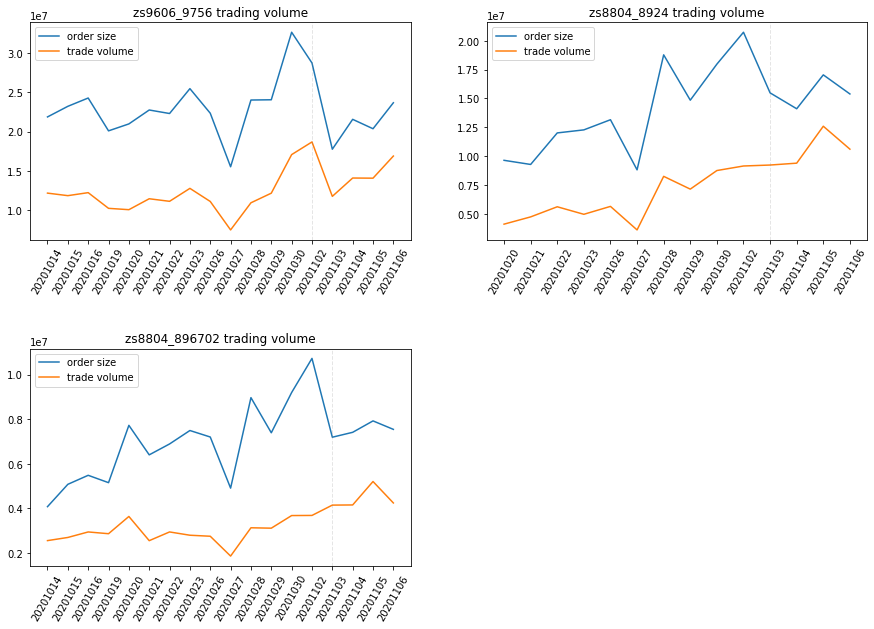

In [45]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(221)

ax.plot(re2[re2['server_account'] == 'zs9606_9756']['absOrderSize'].values, label='order size')
ax.plot(re2[re2['server_account'] == 'zs9606_9756']['absFilledThisUpdate'].values, label='trade volume')
indexLs = [i for i in range(re2[re2['server_account'] == 'zs9606_9756'].shape[0])]
dateLs = [int(i) for i in re2[re2['server_account'] == 'zs9606_9756']['date'].values]
ax.set_xticks(indexLs)
ax.set_xticklabels(dateLs)
ax.legend()
ax.tick_params(labelsize=10)
ax.set_title('zs9606_9756 trading volume')
plt.xticks(rotation=60)
plt.axvline(x=13,ls="--",c="grey", alpha=0.2, lw=1)


ax = fig.add_subplot(222)

ax.plot(re2[re2['server_account'] == 'zs8804_8924']['absOrderSize'].values, label='order size')
ax.plot(re2[re2['server_account'] == 'zs8804_8924']['absFilledThisUpdate'].values, label='trade volume')
indexLs = [i for i in range(re2[re2['server_account'] == 'zs8804_8924'].shape[0])]
dateLs = [int(i) for i in re2[re2['server_account'] == 'zs8804_8924']['date'].values]
ax.set_xticks(indexLs)
ax.set_xticklabels(dateLs)
ax.legend()
ax.tick_params(labelsize=10)
ax.set_title('zs8804_8924 trading volume')
plt.xticks(rotation=60)
plt.axvline(x=10,ls="--",c="grey", alpha=0.2, lw=1)


ax = fig.add_subplot(223)

ax.plot(re2[re2['server_account'] == 'zs8804_896702']['absOrderSize'].values, label='order size')
ax.plot(re2[re2['server_account'] == 'zs8804_896702']['absFilledThisUpdate'].values, label='trade volume')
indexLs = [i for i in range(re2[re2['server_account'] == 'zs8804_896702'].shape[0])]
dateLs = [int(i) for i in re2[re2['server_account'] == 'zs8804_896702']['date'].values]
ax.set_xticks(indexLs)
ax.set_xticklabels(dateLs)
ax.legend()
ax.tick_params(labelsize=10)
ax.set_title('zs8804_896702 trading volume')
plt.xticks(rotation=60)
plt.axvline(x=14,ls="--",c="grey", alpha=0.2, lw=1)


# ax = fig.add_subplot(224)

# ax.plot(re2[re2['server_account'] == 'zs9608_6282']['absOrderSize'].values, label='order size')
# ax.plot(re2[re2['server_account'] == 'zs9608_6282']['absFilledThisUpdate'].values, label='trade volume')
# indexLs = [i for i in range(re2[re2['server_account'] == 'zs9608_6282'].shape[0])]
# dateLs = [int(i) for i in re2[re2['server_account'] == 'zs9608_6282']['date'].values]
# ax.set_xticks(indexLs)
# ax.set_xticklabels(dateLs)
# ax.legend()
# ax.tick_params(labelsize=10)
# ax.set_title('zs9608_6282 trading volume')
# plt.xticks(rotation=60)
# plt.axvline(x=15,ls="--",c="grey", alpha=0.2, lw=1)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=None, hspace=0.5)

plt.show()

In [65]:
[0, 0, 0, 0] + list(re2[re2['server_account'].isin(['zs8804_8924'])]['tradeNtl'].values)

[0,
 0,
 0,
 0,
 70016727.44999999,
 85655083.20000002,
 93567991.14,
 91572238.64,
 104322544.27999999,
 75331908.66,
 159829120.13000003,
 129764587.60000004,
 149546203.52000004,
 158747491.26000005,
 120963867.02000001,
 145066256.63,
 164685129.88999996,
 165552145.02000004]

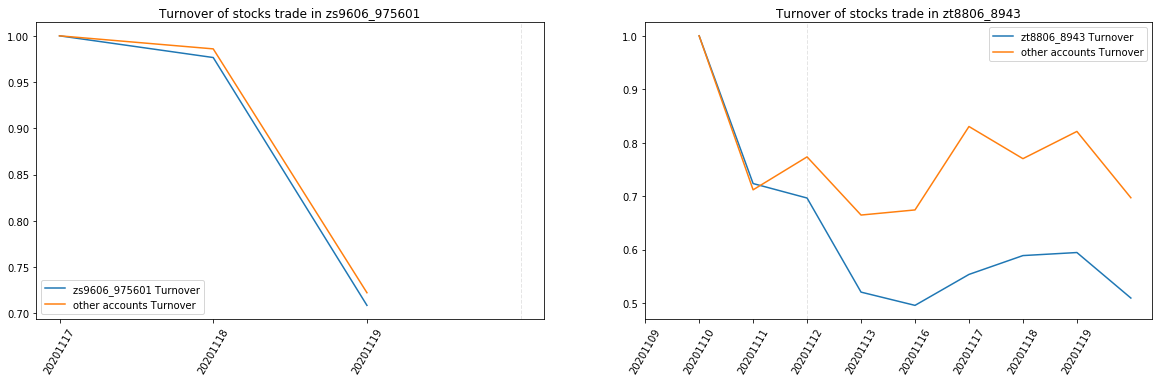

In [25]:
re2 = orderLog[(orderLog['updateType'] == 4)].groupby(['date', 'server_account'])['tradeNtl'].sum().reset_index()
re3 = orderLog[orderLog['updateType'] == 4]
re3 = pd.merge(re3, orderLog[(orderLog['updateType'] == 4) & (orderLog['server_account'] == 'zs9606_975601')]\
         .drop_duplicates(['date', 'secid'])[['date', 'secid']], on=['date', 'secid'], how='inner')
re3 = re3[re3['server_account'] != 'zs9606_975601']
re3 = re3.groupby(['date'])['tradeNtl'].sum().reset_index()


re4 = orderLog[orderLog['updateType'] == 4]
re4 = pd.merge(re4, orderLog[(orderLog['updateType'] == 4) & (orderLog['server_account'] == 'zt8806_8943')]\
         .drop_duplicates(['date', 'secid'])[['date', 'secid']], on=['date', 'secid'], how='inner')
re4 = re4[re4['server_account'] != 'zt8806_8943']
re4 = re4.groupby(['date'])['tradeNtl'].sum().reset_index()


# re5 = orderLog[orderLog['updateType'] == 4]
# re5 = pd.merge(re5, orderLog[(orderLog['updateType'] == 4) & (orderLog['server_account'] == 'zs8804_896702')]\
#          .drop_duplicates(['date', 'secid'])[['date', 'secid']], on=['date', 'secid'], how='inner')
# re5 = re5[re5['server_account'] != 'zs8804_896702']
# re5 = re5.groupby(['date'])['tradeNtl'].sum().reset_index()


fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(221)

ax.plot(re2[re2['server_account'] == 'zs9606_975601']['tradeNtl'].values/re2[re2['server_account'] == 'zs9606_975601']['tradeNtl'].values[0], label='zs9606_975601 Turnover')
ax.plot(re3['tradeNtl'].values/re3['tradeNtl'].values[0], label='other accounts Turnover')
indexLs = [i for i in range(re2[re2['server_account'] == 'zs9606_975601'].shape[0])]
dateLs = [int(i) for i in re2[re2['server_account'] == 'zs9606_975601']['date'].values]
ax.set_xticks(indexLs)
ax.set_xticklabels(dateLs)
ax.legend()
ax.tick_params(labelsize=10)
ax.set_title('Turnover of stocks trade in zs9606_975601')
plt.xticks(rotation=60)
plt.axvline(x=3,ls="--",c="grey", alpha=0.2, lw=1)


ax = fig.add_subplot(222)


ax.plot(([np.nan] + list(re2[re2['server_account'].isin(['zt8806_8943'])]['tradeNtl'].values))/re2[re2['server_account'].isin(['zt8806_8943'])]['tradeNtl'].values[0], label='zt8806_8943 Turnover')
ax.plot(([np.nan] + list(re4['tradeNtl'].values))/re4['tradeNtl'].values[0], label='other accounts Turnover')
indexLs = [i for i in range(re2[re2['server_account'] == 'zt9406_9551'].shape[0])]
dateLs = [int(i) for i in re2[re2['server_account'] == 'zt9406_9551']['date'].values]
ax.set_xticks(indexLs)
ax.set_xticklabels(dateLs)
ax.legend()
ax.tick_params(labelsize=10)
ax.set_title('Turnover of stocks trade in zt8806_8943')
plt.xticks(rotation=60)
plt.axvline(x=3,ls="--",c="grey", alpha=0.2, lw=1)


plt.show()

### 6. Turnover %

In [33]:
orderLog['tag'] = 'before rollout'
orderLog.loc[orderLog['date'] >= 20201103, 'tag'] = 'after rollout'

orderLog1 = orderLog[orderLog['tag'] == 'after rollout']
a = orderLog1.groupby(['date', 'exchange', 'server_account'])['tradeNtl'].sum().reset_index()
l = len(orderLog["date"].unique())
exchangeTurnover = a.groupby(['date', 'exchange'])['tradeNtl'].sum().reset_index()
exchangeTurnover = exchangeTurnover.groupby(['exchange'])['tradeNtl'].mean().reset_index()
exchangeTurnover['tradeNtl'] = (exchangeTurnover['tradeNtl']/10000).astype('int64')
exchangeTurnover.columns = ['exchange', 'exchange turnover']
exchangeTurnover = pd.merge(a, exchangeTurnover, how='left', on=['exchange'], validate='many_to_one')
pp = exchangeTurnover.groupby(['exchange', 'exchange turnover', 'server_account'])["tradeNtl"].count().reset_index()
exchangeTurnover = (exchangeTurnover.groupby(['exchange', 'exchange turnover', 'server_account'])['tradeNtl'].mean()/10000).astype('int64').reset_index()
exchangeTurnover.columns = ['exchange', 'exchange turnover', 'server_account', 'turnover']
exchangeTurnover = pd.merge(exchangeTurnover, pp, on=['exchange', 'exchange turnover', 'server_account'])
exchangeTurnover['turnover %'] = (exchangeTurnover['turnover'] *  exchangeTurnover['tradeNtl'])/ (exchangeTurnover['exchange turnover']*l)
exchangeTurnover = exchangeTurnover[exchangeTurnover['server_account'].isin(['zs9606_9756', 'zs8804_8924', 'zs8804_896702'])]
exchangeTurnover['tag'] = 'after rollout'
exchangeTurnover = exchangeTurnover.groupby(['tag', 'exchange', 'exchange turnover', 'server_account'])[['turnover', 'turnover %']].first()
exchangeTurnover['turnover %'] = exchangeTurnover['turnover %'].apply(lambda x: '%.1f%%'%(100*x))

from IPython.display import display, HTML
display(HTML(exchangeTurnover.to_html()))